# Regression Analysis on Evictions, Poverty, and Race
In the "enhancing-statistical-rigor" notebook it became clear that the EL mislabeled the flag columns:
- imputed -- was accidentally labeled --> low-flag
- subbed -- was accidentally labeled --> imputed
- low-flag -- was accidentally labeled --> subbed.

So, I'll fix the labels and then compare regression analyses on:
- all the data
- filtered data (i.e. drop the data points that have been flagged as low)

In [1]:
import pandas as pd
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.plotly as py
import cufflinks as cf # cufflinks binds plotly to pandas dataframes in IPython notebook.
import plotly.graph_objs as go
from plotly import tools

In [2]:
import plotly.figure_factory as ff

In [618]:
import re

In [3]:
sns.set(style = 'darkgrid')

## - Read in the County Level Data and correct the labels

In [4]:
counties_evicts_df = pd.read_csv('data/counties.csv')
counties_evicts_df.rename(columns = {'low-flag': 'imputed',
                                    'imputed': 'subbed',
                                    'subbed': 'low-flag'}, inplace = True)
counties_evicts_df.head()

GEOID  year             name parent-location  population  poverty-rate  \
0  47001  2000  Anderson County       Tennessee     71330.0         13.14   
1  47003  2000   Bedford County       Tennessee     37586.0         13.14   
2  47005  2000    Benton County       Tennessee     16537.0         15.63   
3  47007  2000   Bledsoe County       Tennessee     12367.0         18.07   
4  47009  2000    Blount County       Tennessee    105823.0          9.73   

   pct-renter-occupied  median-gross-rent  median-household-income  \
0                27.49              450.0                  35483.0   
1                26.46              488.0                  36729.0   
2                19.47              367.0                  28679.0   
3                18.24              343.0                  28982.0   
4                24.11              450.0                  37862.0   

   median-property-value    ...     pct-multiple  pct-other  \
0                87500.0    ...             1.14       0.07   
1                79000.0    ...             0.77       0.05   
2                67000.0    ...             0.62       0.03   
3                67200.0    ...             1.03       0.02   
4               103900.0    ...             0.88       0.05   

   renter-occupied-households  eviction-filings  evictions  eviction-rate  \
0                      8189.0             125.0      118.0           1.44   
1                      3679.0             104.0       98.0           2.66   
2                      1336.0              17.0       17.0           1.27   
3                       808.0               0.0        0.0           0.00   
4                     10286.0             210.0      201.0           1.95   

   eviction-filing-rate  imputed  subbed  low-flag  
0                  1.53        0       0         1  
1                  2.83        0       0         0  
2                  1.27        0       0         0  
3                  0.00        0       0         0  
4                  2.04        0       0         1  

[5 rows x 27 columns]

Confirm my 'low-flag' column corroborates the criteria stated in pg. 40 of the methodology report
- *i.e. that at least 25% of the counties between 2009 - 2016 are flagged as low*
    - that's from January 1st 2009 - January 1st 2016

In [5]:
cty_09_15_index = [year in range(2009, 2016) for year in counties_evicts_df.year]
print('LEFT-INCLUSIVE, RIGHT-EXCLUSIVE:') 
print("---------------------------------")
print('Years in range(2009, 2016)=', list(range(2009, 2016)))
print("")
print('Fraction of TN counties labeled as low:', counties_evicts_df[cty_09_15_index]['low-flag'].sum()/len(counties_evicts_df[cty_09_15_index]))
      

LEFT-INCLUSIVE, RIGHT-EXCLUSIVE:
---------------------------------
Years in range(2009, 2016)= [2009, 2010, 2011, 2012, 2013, 2014, 2015]

Fraction of TN counties labeled as low: 0.24661654135338346


## - Pre-process the data for visualization and regression analysis
- pivot the counties for time series analysis

In [6]:
pivoted_counties = counties_evicts_df.pivot(index = 'year', columns = 'name', values= 'poverty-rate')
pivoted_counties.head()

name  Anderson County  Bedford County  Benton County  Bledsoe County  \
year                                                                   
2000            13.14           13.14          15.63           18.07   
2001            13.14           13.14          15.63           18.07   
2002            13.14           13.14          15.63           18.07   
2003            13.14           13.14          15.63           18.07   
2004            13.14           13.14          15.63           18.07   

name  Blount County  Bradley County  Campbell County  Cannon County  \
year                                                                  
2000           9.73           12.22            22.83          12.77   
2001           9.73           12.22            22.83          12.77   
2002           9.73           12.22            22.83          12.77   
2003           9.73           12.22            22.83          12.77   
2004           9.73           12.22            22.83          12.77   

name  Carroll County  Carter County      ...        Unicoi County  \
year                                     ...                        
2000           13.89          16.85      ...                13.05   
2001           13.89          16.85      ...                13.05   
2002           13.89          16.85      ...                13.05   
2003           13.89          16.85      ...                13.05   
2004           13.89          16.85      ...                13.05   

name  Union County  Van Buren County  Warren County  Washington County  \
year                                                                     
2000         19.62             15.24          16.59              13.95   
2001         19.62             15.24          16.59              13.95   
2002         19.62             15.24          16.59              13.95   
2003         19.62             15.24          16.59              13.95   
2004         19.62             15.24          16.59              13.95   

name  Wayne County  Weakley County  White County  Williamson County  \
year                                                                  
2000          16.3           16.04         14.26               4.72   
2001          16.3           16.04         14.26               4.72   
2002          16.3           16.04         14.26               4.72   
2003          16.3           16.04         14.26               4.72   
2004          16.3           16.04         14.26               4.72   

name  Wilson County  
year                 
2000           6.66  
2001           6.66  
2002           6.66  
2003           6.66  
2004           6.66  

[5 rows x 95 columns]

In [7]:
layout = go.Layout(
    autosize = True,
    #rangeslider = True,
    #width = 1600, 
    height = 800)

pivoted_counties.iplot(filename='pivoted-tn-county-poverty-timeseries', sharing = 'public',
                       #layout = layout,
                       width = 1, dash = 'line', mode = 'lines',
                      title = 'TN County Poverty Rate, 2000 - 2016', yTitle = 'Poverty %', xTitle = 'Year'
                      #rangeslider = True, 
                       )

## - Visualizing flagged data in the eviction rate time series for all counties
can recycle this routine for other variable time-series

In [8]:
pvt_cnty_evic_rates = counties_evicts_df.pivot(index = 'year', columns = 'name', values= ['eviction-rate', 'low-flag'])

In [9]:
pvt_cnty_evic_rates.head(2)


eviction-rate                                              \
name Anderson County Bedford County Benton County Bledsoe County   
year                                                               
2000            1.44           2.66          1.27            0.0   
2001            2.02           2.89          2.21            0.0   

                                                                 \
name Blount County Bradley County Campbell County Cannon County   
year                                                              
2000          1.95            NaN            1.75          0.47   
2001          2.37           2.12            1.94          0.09   

                                       ...           low-flag               \
name Carroll County Carter County      ...      Unicoi County Union County   
year                                   ...                                   
2000           1.13           NaN      ...                1.0          0.0   
2001           1.19          2.38      ...                0.0          0.0   

                                                                    \
name Van Buren County Warren County Washington County Wayne County   
year                                                                 
2000              0.0           0.0               0.0          1.0   
2001              0.0           0.0               1.0          0.0   

                                                                  
name Weakley County White County Williamson County Wilson County  
year                                                              
2000            0.0          0.0               1.0           0.0  
2001            0.0          0.0               1.0           0.0  

[2 rows x 190 columns]

In [10]:
def mutate_traces_by_flag(df):
    '''Takes a timeseries df with two column levels and
    splits columns in one level according to values in the second level.
    It transfers the values from the first level to the second level; overwriting the second level.
    Returns the mutated df (with two levels)'''
    if len(df.columns.levels[0]) != 2:
        print('Need df with two levels of columns. Received df.columns.levels[0] = ',
             df.columns.levels[0])
        assert df.columns.levels[0] == 2
    # store level 1 and 2
    lv0 = df.columns.levels[0][0]
    lv1 = df.columns.levels[0][1]
    
    dfo = df.copy(deep = True)
    # for each col in lv0
    for col in dfo[lv0].columns:
        # for each year in that column
        for year in dfo.index:
            # if variable is flagged
            if dfo[lv1][col][year] == 1:
                # paste the flagged value into the flag col
                dfo[lv1][col][year] = dfo[lv0][col][year]
                # replace that value with None
                dfo[lv0][col][year] = None
            else:
                dfo[lv1][col][year] == None
                
    return dfo

In [11]:
def split_trace_by_flag(df, verbose = False):
    '''Takes a timeseries df with two column levels and 
    splits each column from first level into two columns according to whether or not 
    that cell has been flagged in the other level.
    Returns a one level df with twice as many columns'''
    if len(df.columns.levels[0]) != 2:
        print('Need df with two levels of columns. Received df.columns.levels[0] = ',
             df.columns.levels[0])
        assert df.columns.levels[0] == 2
    # store level 1 and 2
    lv0 = df.columns.levels[0][0]
    lv1 = df.columns.levels[0][1]
    
    # initialize copy of df to work on
    dfo = df[lv0].copy(deep = True)
    
    # for each col in dfo
    for col in dfo.columns:
        # initialize a flag column
        fcol = str(col)+' flagged'
        if verbose:
            print(fcol)
        dfo[fcol] = None
        # for each year in that column
        for year in dfo.index:
            if verbose:
                print(year)
            # if variable is flagged
            if df[lv1][col][year] == 1:
                # paste the flagged value into the flag col
                dfo[fcol][year] = df[lv0][col][year]
                # replace that value with None
                #dfo[col][year] = None
                
    return dfo

In [12]:
split_cnty_evic_rates = split_trace_by_flag(pvt_cnty_evic_rates)

In [13]:
split_cnty_evic_rates.sort_index(axis = 1, inplace=True)

In [14]:
split_cnty_evic_rates.head(2)

name  Anderson County Anderson County flagged  Bedford County  \
year                                                            
2000             1.44                    1.44            2.66   
2001             2.02                    2.02            2.89   

name Bedford County flagged  Benton County Benton County flagged  \
year                                                               
2000                   None           1.27                  None   
2001                   None           2.21                  None   

name  Bledsoe County Bledsoe County flagged  Blount County  \
year                                                         
2000             0.0                   None           1.95   
2001             0.0                   None           2.37   

name Blount County flagged          ...           Wayne County  \
year                                ...                          
2000                  1.95          ...                   0.29   
2001                  2.37          ...                   0.87   

name Wayne County flagged  Weakley County Weakley County flagged  \
year                                                               
2000                 0.29            1.40                   None   
2001                 None            1.52                   None   

name  White County White County flagged  Williamson County  \
year                                                         
2000           NaN                 None               1.65   
2001           NaN                 None               1.53   

name Williamson County flagged  Wilson County Wilson County flagged  
year                                                                 
2000                      1.65           2.61                  None  
2001                      1.53           2.95                  None  

[2 rows x 190 columns]

In [15]:
split_cnty_evic_rates.iplot(filename='pivoted-tn-county-eviction-rate-timeseries', sharing = 'public',
                       #width = 1, dash = 'line', mode = 'lines',
                          mode = 'marker',
                            
                      title = 'TN Counties Eviction Rates, 2000 - 2016', yTitle = '%', xTitle = 'Year',
                      rangeslider = False, 
                       )

Let's try to just add a trace of red markers over the flagged values

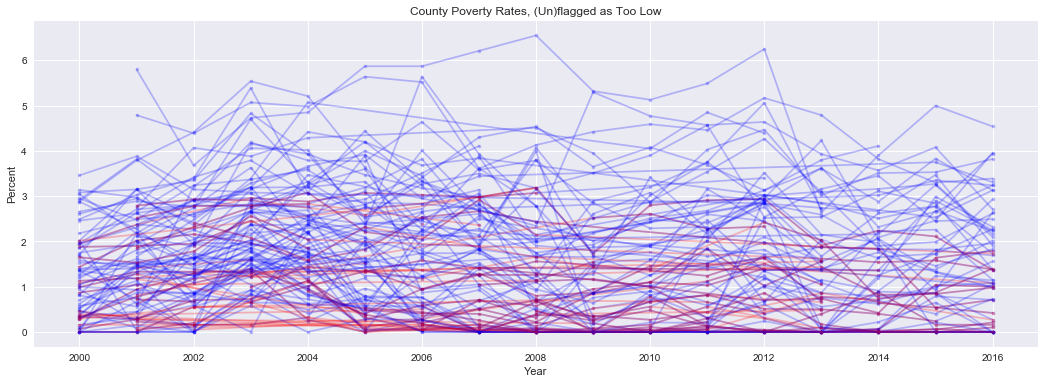

In [16]:
for col in split_cnty_evic_rates:
    if 'flagged' not in col:
        try:
            split_cnty_evic_rates[col].dropna().plot(figsize = (18, 6), color = 'blue', alpha = .25, marker = '.')
        except:
            continue
    if 'flagged' in col:
        try:
            split_cnty_evic_rates[col].dropna().plot(figsize = (18, 6), color = 'red', alpha = .25, marker = '.')
        except:
            continue

#plt.figure(figsize=(18, 6))
plt.title('County Poverty Rates, (Un)flagged as Too Low')
plt.xlabel('Year')
plt.ylabel('Percent')
plt.show()

To achieve this in Plotly I'll have to make two traces for every county, then I'll have to plot all 190 ish traces specifying the color of each trace. 

pseudo-code:

initialize 190ish variables

for each county assign a scatter graph object to it's two corresponding variables
append the trace to the data to be ploted by plotly. 

## - Compare flagged and unflagged eviction data

In [18]:
poverty_trace = go.Box(
    y = counties_evicts_df['poverty-rate'],
    x = counties_evicts_df.year,
    name = 'TN Poverty Rates',
    opacity = 0.25,
    marker = dict(color = 'black', opacity = 0.25, symbol = 'square')
)
bonafide_eviction_trace = go.Box(
    y = counties_evicts_df['eviction-rate'][counties_evicts_df['low-flag'] == 0],
    x = counties_evicts_df['year'][counties_evicts_df['low-flag'] == 0],
    name = 'TN Bonafide Eviction Rates',
    opacity = 0.5,
    marker = dict(color = 'red', opacity = 0.5, symbol = 'square')
)
flagged_poverty_trace = go.Box(
    y = counties_evicts_df['eviction-rate'][counties_evicts_df['low-flag'] == 1],
    x = counties_evicts_df['year'][counties_evicts_df['low-flag'] == 1],
    name = 'TN Low-Flagged Eviction Rates',
    opacity = 0.5,
    marker = dict(color = 'pink', opacity = 0.5, symbol = 'square')
)

eviction_trace = go.Box(
    y = counties_evicts_df['eviction-rate'],
    x = counties_evicts_df.year,
    name = 'TN Eviction Rates',
    opacity = 0.5,
    marker = dict(color = 'blue', opacity = 0.5, symbol = 'square')
)

data = [poverty_trace, eviction_trace, flagged_poverty_trace, bonafide_eviction_trace]

layout = go.Layout(
    title = 'TN Poveryt, Eviction, & Filing Rates (Boxplot Timeseries)',
    yaxis = dict(title = 'Percent'),
    xaxis = dict(title = 'Year'),
    boxmode = 'group'
)
fig = go.Figure(data = data, layout = layout)
py.iplot(fig,
        filename = 'tn-eviction-poverty-boxplot-timeseries', fileopt = 'overwrite', sharing = 'public')

It's clear that once we filter out the rows that have been flagged as low we have a significant increase in the "center" of our distributions. 
- the median on the filtered data looks to be about .5% higher

Unfortunately the boxplot is actually obscuring how dense the distribution of values is. Let's try it again with some violin plots.

In [20]:
fig = ff.create_violin(counties_evicts_df.dropna(), data_header = 'eviction-rate', group_header = 'year', 
                       height = 500, width = 800)
py.iplot(fig,
        filename = 'tn-eviction-poverty-boxplot-timeseries', fileopt = 'overwrite', sharing = 'public')

⚠️ this doesn't look right. Maybe my dropna call removed entire rows instead of just cells. 
- Also it seems like I actually have a figure for every violin, which makes it akward to try and use the tools (like zooming and panning)

## - Compare regression plots of filtered and unflitered data

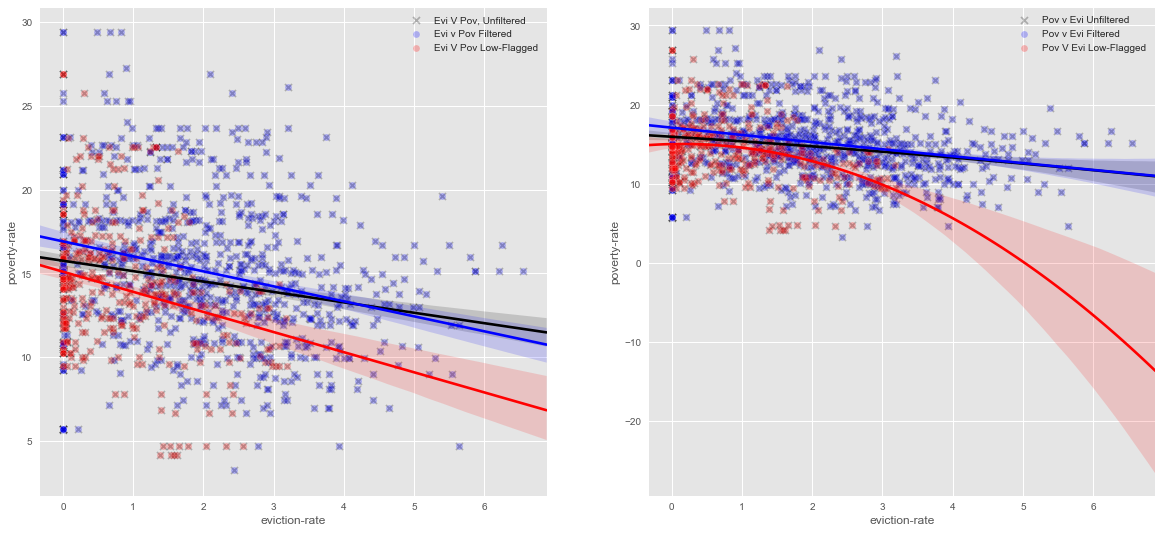

In [866]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey = False, figsize = (20, 9))

# add unfiltered linear regression to axis 1
sns.regplot(y = counties_evicts_df['poverty-rate'],
           x = counties_evicts_df['eviction-rate'],
            robust = True,
           color = 'black', marker = 'x', scatter_kws = {'alpha':'.25', 
                                            'edgecolors':'white',
                                           'linewidths':'.5'},
            label = 'Evi V Pov, Unfiltered',
           ax = ax1)
# add filtered regression to axis 1
sns.regplot(y = counties_evicts_df['poverty-rate'][counties_evicts_df['low-flag'] == 0],
           x = counties_evicts_df['eviction-rate'][counties_evicts_df['low-flag'] == 0],
            robust = True,
           color = 'blue', marker = 'o', scatter_kws = {'alpha':'.25', 
                                            'edgecolors':'white',
                                           'linewidths':'.5'},
            label = 'Evi v Pov Filtered',
           ax = ax1)
# add low-flagged regression to axis 1
sns.regplot(y = counties_evicts_df['poverty-rate'][counties_evicts_df['low-flag'] == 1],
           x = counties_evicts_df['eviction-rate'][counties_evicts_df['low-flag'] == 1],
            robust = True,
           color = 'red', marker = 'o', scatter_kws = {'alpha':'.25', 
                                            'edgecolors':'white',
                                           'linewidths':'.5'},
            label = 'Evi V Pov Low-Flagged',
           ax = ax1)
ax1.legend()

sns.regplot(y = counties_evicts_df['poverty-rate'],
           x = counties_evicts_df['eviction-rate'],
            order = 2, robust = False,
           color = 'black', marker = 'x', scatter_kws = {'alpha':'.25', 
                                            'edgecolors':'white',
                                           'linewidths':'.5'},
            label = 'Pov v Evi Unfiltered',
           ax = ax2)
sns.regplot(y = counties_evicts_df['poverty-rate'][counties_evicts_df['low-flag'] == 0],
           x = counties_evicts_df['eviction-rate'][counties_evicts_df['low-flag'] == 0],
            order = 2, robust = False,
           color = 'blue', marker = 'o', scatter_kws = {'alpha':'.25', 
                                            'edgecolors':'white',
                                           'linewidths':'.5'},
            label = 'Pov v Evi Filtered',
           ax = ax2)

sns.regplot(y = counties_evicts_df['poverty-rate'][counties_evicts_df['low-flag'] == 1],
           x = counties_evicts_df['eviction-rate'][counties_evicts_df['low-flag'] == 1],
            robust = False, order = 2,
           color = 'red', marker = 'o', scatter_kws = {'alpha':'.25', 
                                            'edgecolors':'white',
                                           'linewidths':'.5'},
            label = 'Pov V Evi Low-Flagged',
           ax = ax2)
ax2.legend()
plt.show()

**Initial Observations:**
- the filtered data seems to display a slightly steeper slope i.e. a slightly stronger negative correlation.
- Also the confidence intervals are better for the first order liner regression

# Let's facet out this analysis by year

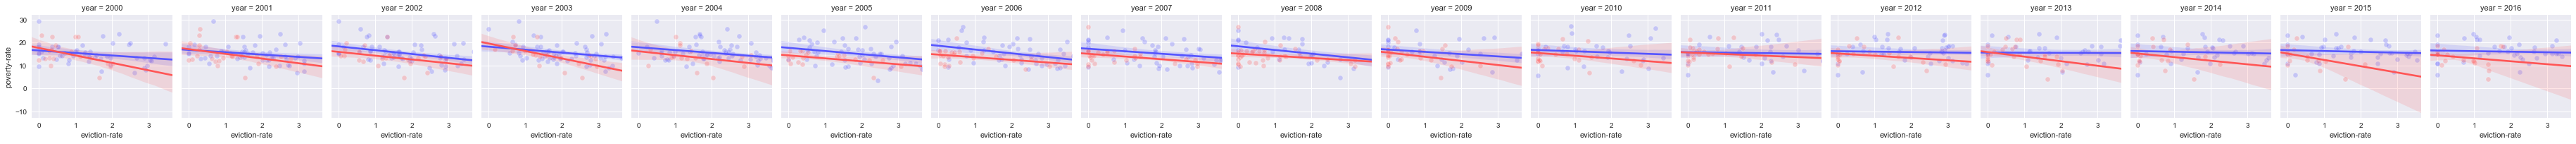

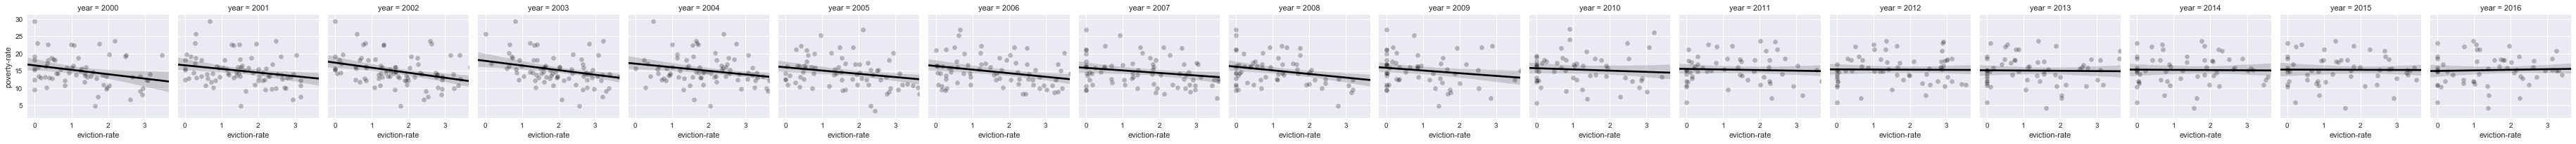

In [179]:
g = sns.FacetGrid(counties_evicts_df, col = 'year', #col_wrap = 9,
                  hue = 'low-flag', palette = 'seismic')
g = g.map(sns.regplot, 'eviction-rate', 'poverty-rate',
          #color = 'black', 
          scatter_kws = {'alpha':'.25', 
                                            'edgecolors':'white',
                                           'linewidths':'1'})

g = sns.FacetGrid(counties_evicts_df, col = 'year')
g = g.map(sns.regplot, 'eviction-rate', 'poverty-rate',
          color = 'black', scatter_kws = {'alpha':'.25', 
                                            'edgecolors':'white',
                                           'linewidths':'1'})

### Initial Observations:
- **looks like the correlation got leveled off sharply after 2009. Which is interesting. The housing crisis seems to have "broken" the relationship between evictions and poverty.** 

# Compare regression plots of bonafide vs low-flagged Data

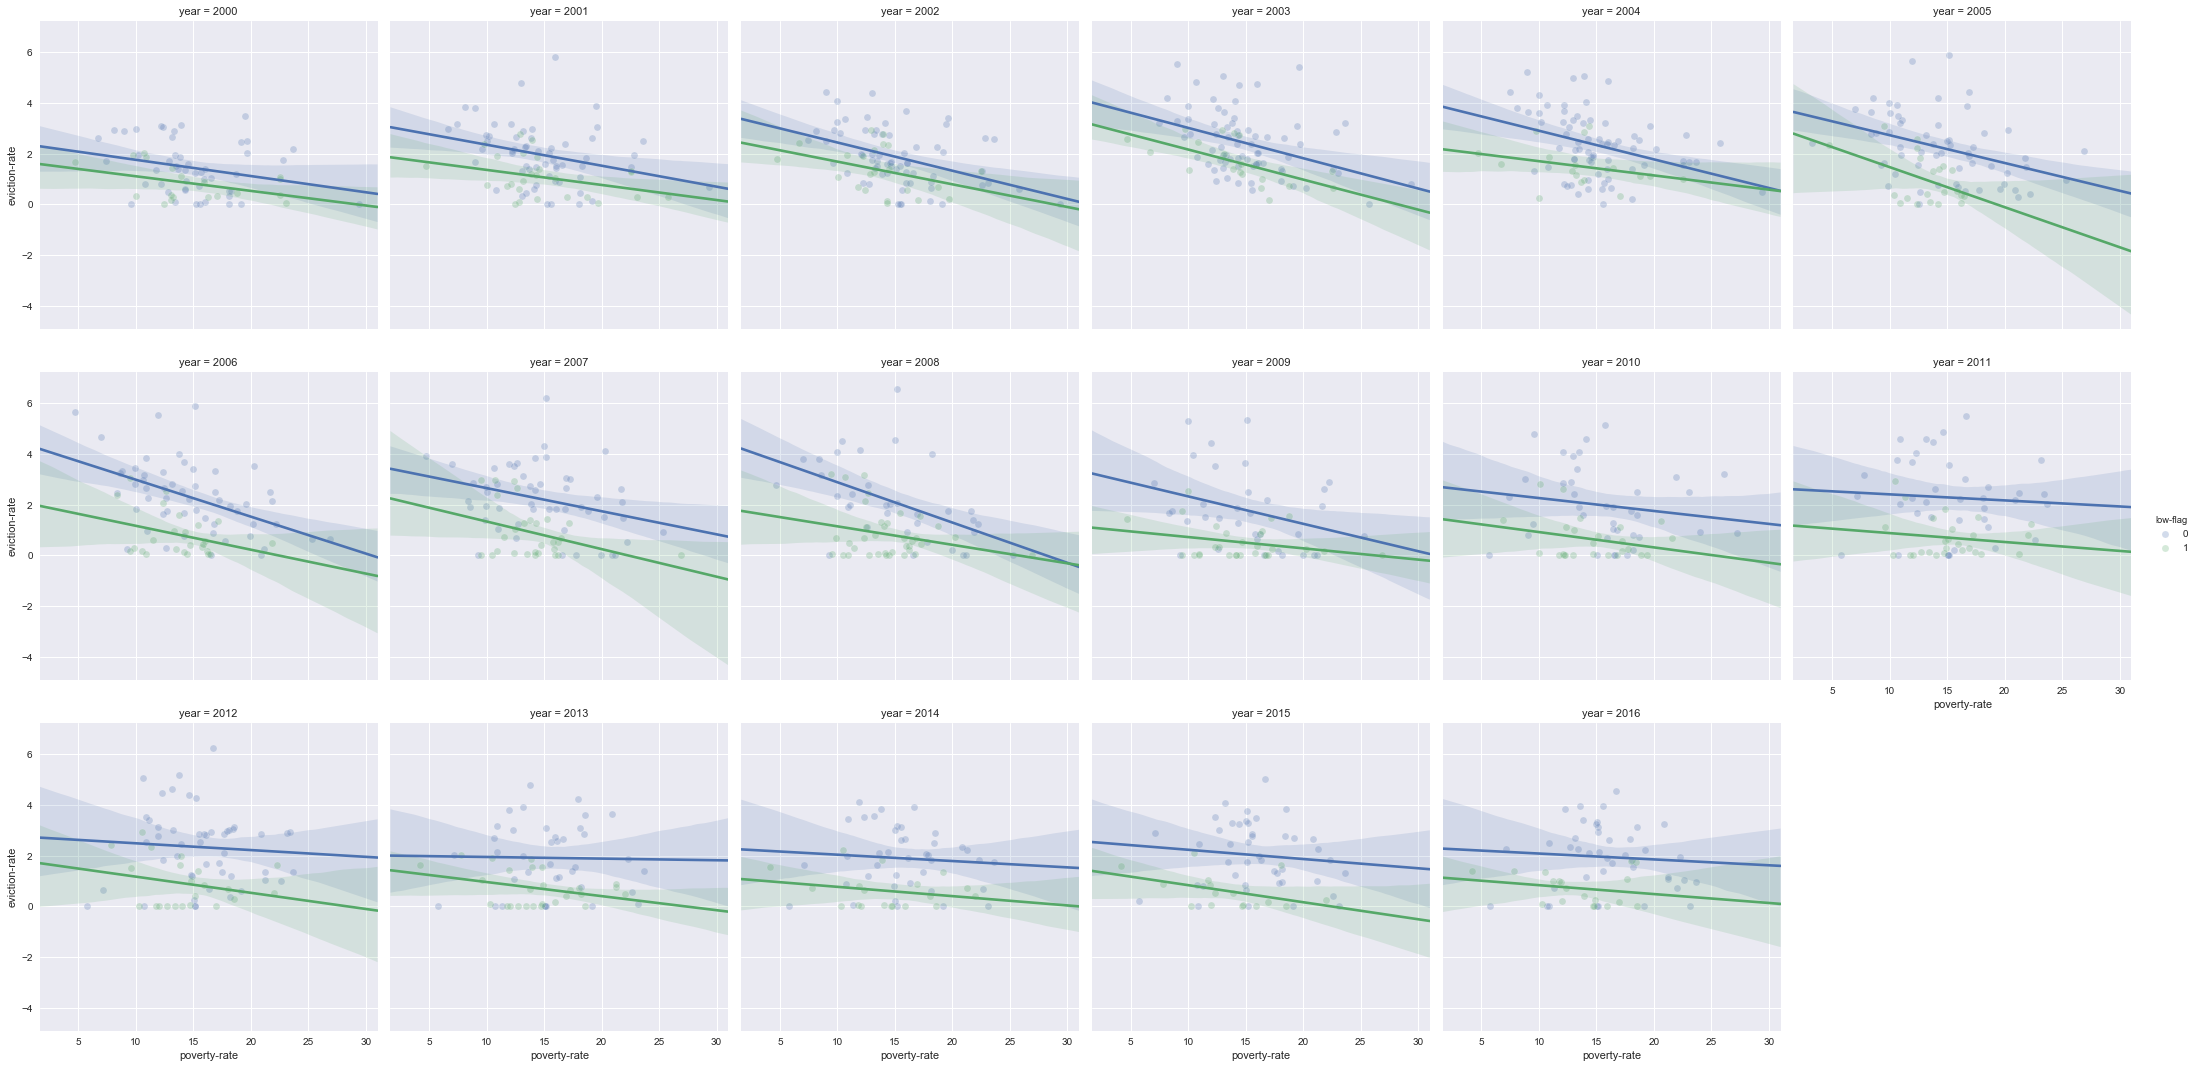

In [153]:
sns.lmplot(x = 'poverty-rate',
           y = 'eviction-rate',
           hue = 'low-flag',
           col = 'year', col_wrap = 6,
           data = counties_evicts_df,
           scatter_kws = {'alpha':'.25', 
                          'edgecolors':'white',
                          'linewidths':'.5'})
plt.show()

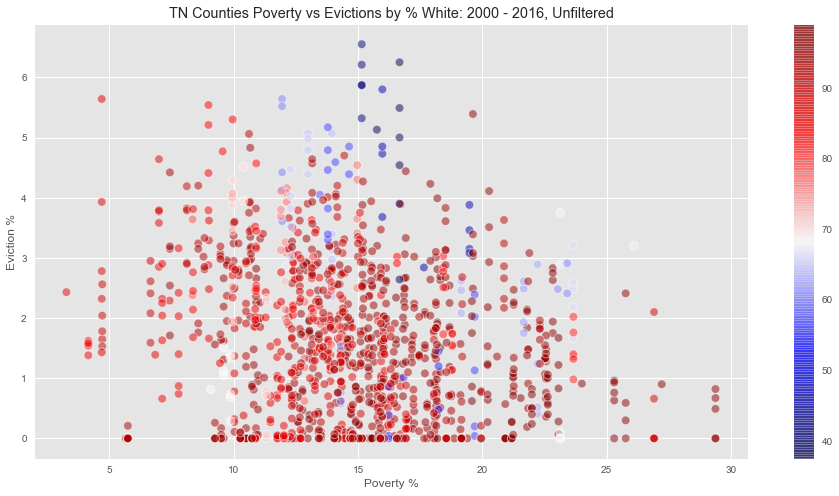

In [681]:
plt.figure(figsize=(16,8))
plt.scatter(x = 'poverty-rate', y = 'eviction-rate', data = counties_evicts_df, 
            edgecolors= 'white', linewidths=1, s = 75,
            alpha = .5, c = 'pct-white', cmap = 'seismic')
plt.title('TN Counties Poverty vs Evictions by % White: 2000 - 2016, Unfiltered')
plt.xlabel('Poverty %')
plt.ylabel('Eviction %')
cbar = plt.colorbar()
plt.show()

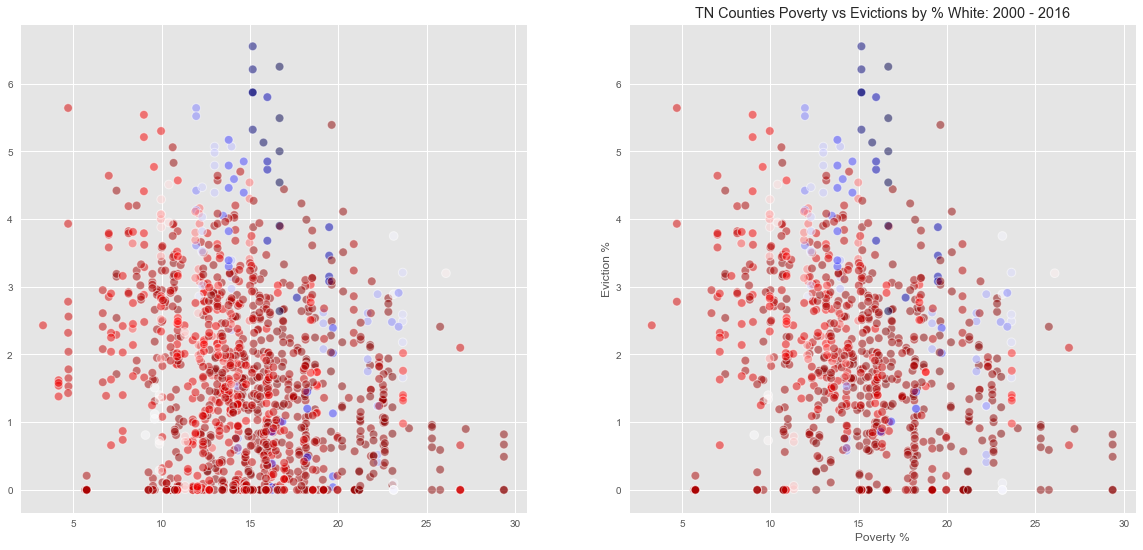

In [868]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey = False, figsize = (20, 9))

ax1.scatter(x = 'poverty-rate', y = 'eviction-rate', data = counties_evicts_df, 
            edgecolors= 'white', linewidths=1, s = 75,
            alpha = .5, c = 'pct-white', cmap = 'seismic')
#ax1.legend()

ax2.scatter(x = 'poverty-rate', y = 'eviction-rate', 
            data = counties_evicts_df[counties_evicts_df['low-flag'] == 0], 
            edgecolors= 'white', linewidths=1, s = 75,
            alpha = .5, c = 'pct-white', cmap = 'seismic')

plt.xlabel('Poverty %')
plt.ylabel('Eviction %')
plt.title('TN Counties Poverty vs Evictions by % White: 2000 - 2016')
#cbar = f.colorbar(mappable = c, ax=ax1)
#cbar = plt.colorbar()
plt.show()

**This is interesting, when comparing it to the unfiltered data the distribution looks significantly "thinned out." However, at first blush it seems as if we have filtered out many more "whiter" counties than "non-white" counties.**

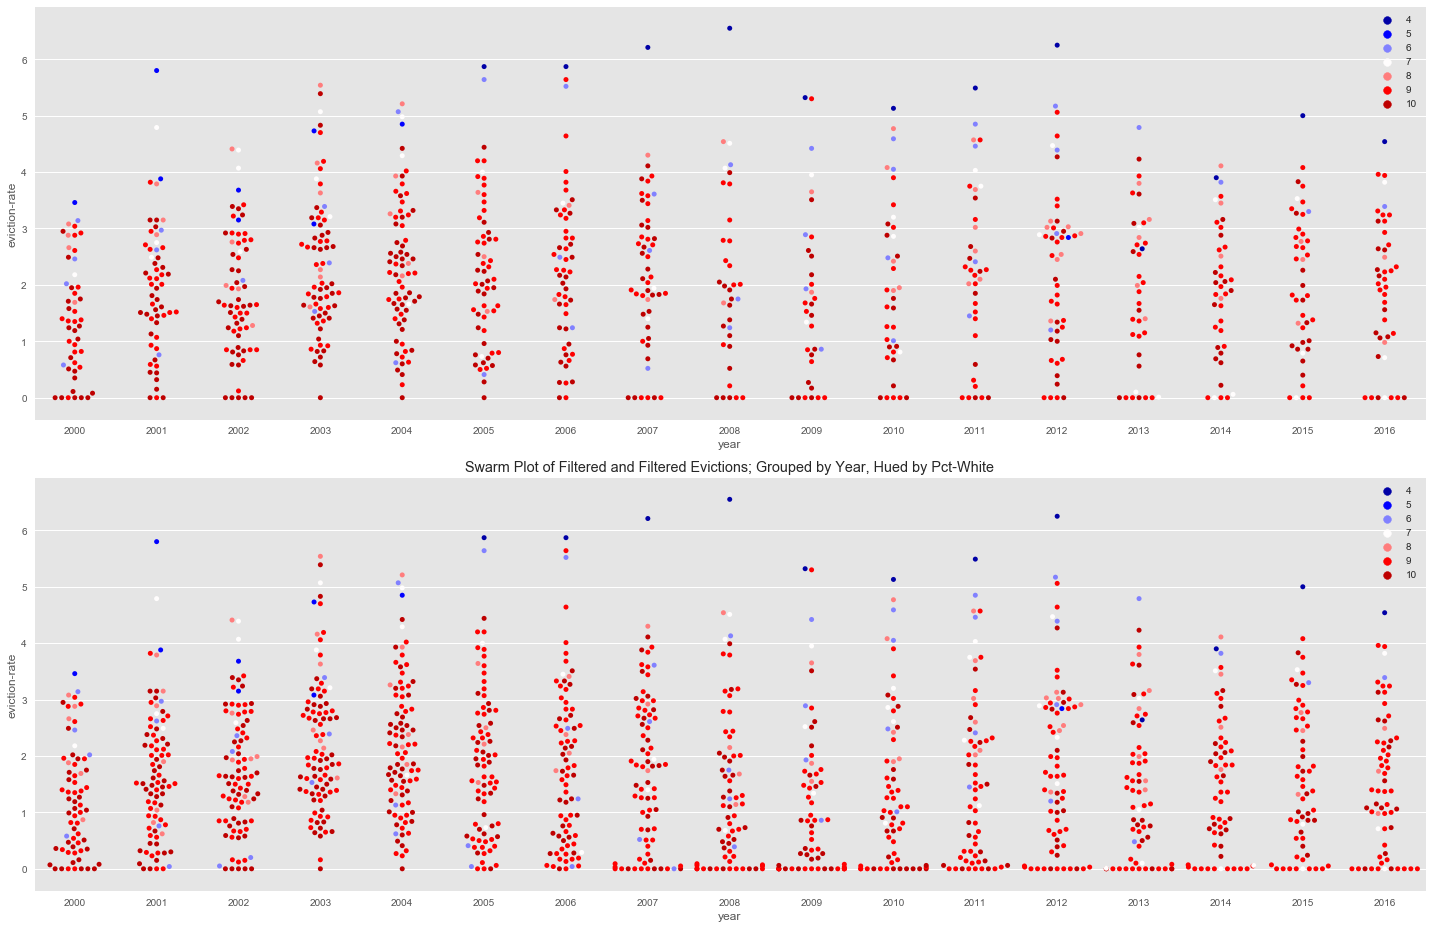

In [871]:
#plt.figure(figsize=(18,6))
f, (ax1, ax2) = plt.subplots(2, 1, sharey = False, figsize = (20, 13))


sns.swarmplot(x = counties_evicts_df['year'][counties_evicts_df['low-flag'] == 0], 
                   y = counties_evicts_df['eviction-rate'][counties_evicts_df['low-flag'] == 0], 
                   hue = [round(val/10) for val in counties_evicts_df['pct-white']] , palette = 'seismic',
                  ax = ax1)
plt.title('Swarm Plot of Filtered and Filtered Evictions; Grouped by Year, Hued by Pct-White')


sns.swarmplot(x = counties_evicts_df['year'], 
                   y = counties_evicts_df['eviction-rate'], 
                   hue = [round(val/10) for val in counties_evicts_df['pct-white']] , palette = 'seismic',
                  ax = ax2)
f.tight_layout()
#plt.show()

# Look at correlation matrix of the data
Which variables are suitable for correlation measurements?
- Do I need to adjust anything from the scales?

In [115]:
corr = counties_evicts_df[[
    'population', 'renter-occupied-households', 'evictions', 'eviction-filings',
    'median-gross-rent', 'median-household-income', 'median-property-value',
    'poverty-rate', 'pct-renter-occupied', 'rent-burden', 
    'pct-white', 'pct-af-am', 'pct-hispanic',
    'eviction-rate', 'eviction-filing-rate'
]].corr()

In [686]:
corr.head(3)

population  renter-occupied-households  evictions  \
population                    1.000000                    0.986363   0.947501   
renter-occupied-households    0.986363                    1.000000   0.959308   
evictions                     0.947501                    0.959308   1.000000   

                            eviction-filings  median-gross-rent  \
population                          0.913979           0.431808   
renter-occupied-households          0.918307           0.386603   
evictions                           0.950431           0.372498   

                            median-household-income  median-property-value  \
population                                 0.347254               0.357792   
renter-occupied-households                 0.271319               0.289854   
evictions                                  0.237366               0.261364   

                            poverty-rate  pct-renter-occupied  rent-burden  \
population                     -0.208889             0.508642     0.136886   
renter-occupied-households     -0.147021             0.539659     0.140109   
evictions                      -0.089584             0.524560     0.165361   

                            pct-white  pct-af-am  pct-hispanic  eviction-rate  \
population                  -0.528802   0.467912      0.312423       0.520225   
renter-occupied-households  -0.537473   0.475853      0.320560       0.492939   
evictions                   -0.606146   0.552686      0.410187       0.516409   

                            eviction-filing-rate  
population                              0.838343  
renter-occupied-households              0.818223  
evictions                               0.826302

In [117]:
mask = np.zeros_like(corr, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

## Let's compare this to the correlation matrix of the filtered data
(i.e. where we drop all the rows that were flagged as having eviction data that was "too low.")

In [119]:
corr_filtered = counties_evicts_df[counties_evicts_df['low-flag'] == 0][[
    'population', 'renter-occupied-households', 'evictions', 'eviction-filings',
    'median-gross-rent', 'median-household-income', 'median-property-value',
    'poverty-rate', 'pct-renter-occupied', 'rent-burden', 
    'pct-white', 'pct-af-am', 'pct-hispanic',
    'eviction-rate', 'eviction-filing-rate'
]].corr()

In [120]:
mask_filtered = np.zeros_like(corr_filtered, dtype = np.bool)
mask_filtered[np.triu_indices_from(mask_filtered)] = True

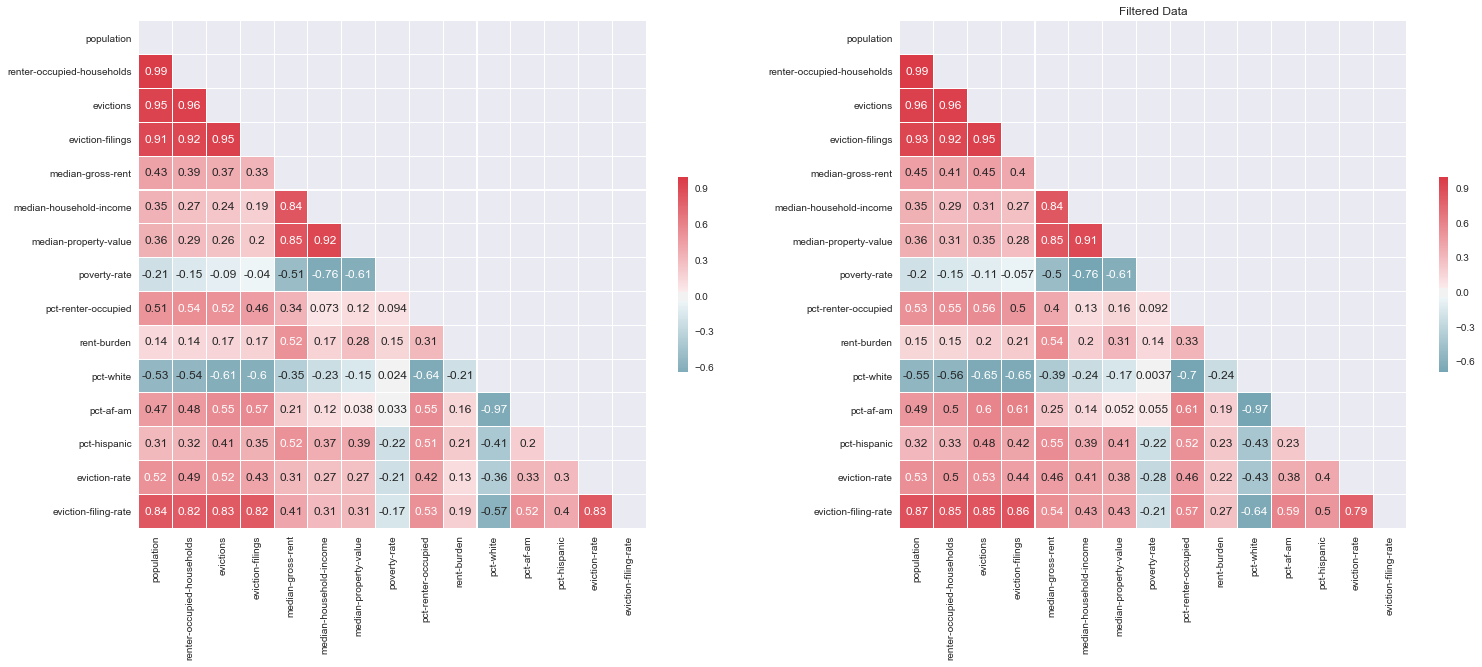

In [134]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey = False, figsize = (25,12) )

# plot the unfiltered correlation matrix heatmap
sns.heatmap(corr, mask = mask, cmap = cmap, annot = True, cbar = True,
            robust = True,
           center = 0, square = True, linewidth = 0.1, 
            cbar_kws = {'shrink': 0.3}, 
            ax = ax1)

# plot the filtered correlation matrix heatmap
sns.heatmap(corr_filtered, mask = mask_filtered, cmap = cmap, annot = True,
           robust = True, center = 0, square = True, linewidth = 0.05,
           cbar_kws = {'shrink' : 0.3},
            ax = ax2)
plt.title('Filtered Data')
plt.show()

## That's interesting!
### poverty-rate
#### - is negatively correlated to everything except:
- 0.15, rent-burden, a weak correlation that makes sense
- 0.094, pct-renter-occupied
    - **actually, this is interesting** It suggests that whether there are or are not a lot of renters in your county does not impact whether or not there is poverty in your county. 
- **0.024, pct-white, the lowest of all the correlation coefficients** showing that a county being whiter has virtually no impact on poverty
#### - is interestingly weakly negatively correlated to:
- -0.21 eviction rate: suggesting gentrification? Or the ejection or displacement of people in poverty?
    - Where are these people ending up?
- -0.17 eviction filing rate, suggesting that pressuring 
#### - is strongly negatively (and unsurprisingly) correlated to
- measures of a countie's wealth:
    - 0.76, median-household-income
    - 0.61, median-property-value
    - 0.51, median-gross-rent

# -------------------------------------

# I. Correlation of Evictions/Filings to Poverty in General
1. At a national level, how do evictions, filings, and poverty correlate?
    - hold off until I get the national traces
2. At the state level, how do evictions, filings, and poverty correlate?
- 
- What is the time series like?
    - see the EDA notebook
- What does the map look like?
    - would like a topographical map showing net gains or falls in each metric
    - heatmap for evictions
        - could also do labels, (e, f) = (+1, +2)
    - topography for poverty?

## I.b) At the State Level, How do Evictions, Filings, and Poverty correlate in TN?

### State Level Correlations Across years

In [694]:
tn_state_df = pd.read_csv('data/states.csv')
tn_state_df.head()

GEOID  year       name parent-location  population  poverty-rate  \
0     47  2000  Tennessee             USA   5689283.0         13.48   
1     47  2001  Tennessee             USA   5689283.0         13.48   
2     47  2002  Tennessee             USA   5689283.0         13.48   
3     47  2003  Tennessee             USA   5689283.0         13.48   
4     47  2004  Tennessee             USA   5689283.0         13.48   

   pct-renter-occupied  median-gross-rent  median-household-income  \
0                30.07              505.0                  36360.0   
1                30.07              505.0                  36360.0   
2                30.07              505.0                  36360.0   
3                30.07              505.0                  36360.0   
4                30.07              505.0                  36360.0   

   median-property-value   ...    pct-multiple  pct-other  \
0                93000.0   ...            0.96       0.08   
1                93000.0   ...            0.96       0.08   
2                93000.0   ...            0.96       0.08   
3                93000.0   ...            0.96       0.08   
4                93000.0   ...            0.96       0.08   

   renter-occupied-households  eviction-filings  evictions  eviction-rate  \
0                    216654.0            4327.0     4012.0           1.85   
1                    644469.0           40308.0    21137.0           3.28   
2                    670555.0           34087.0    19987.0           2.98   
3                    697749.0           48211.0    24730.0           3.54   
4                    701332.0           49125.0    25011.0           3.57   

   eviction-filing-rate  low-flag  imputed  subbed  
0                  2.00         1        0       0  
1                  6.25         1        0       0  
2                  5.08         1        0       0  
3                  6.91         1        0       0  
4                  7.00         1        0       0  

[5 rows x 27 columns]

In [716]:
tn_census_years = [y in [2000, 2005, 2010, 2011] for y in tn_state_df['year']]

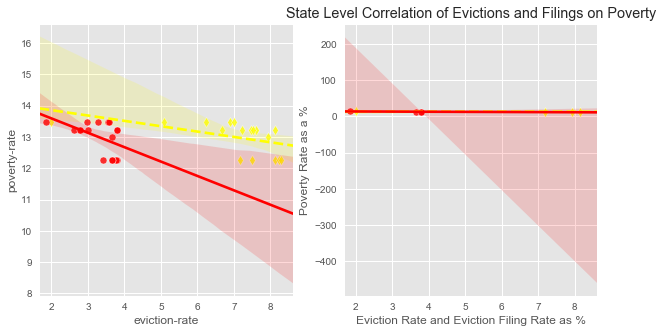

In [734]:
f, (ax1, ax2) = plt.subplots(1, 2, 
                        figsize = (10, 5), 
                        sharex = True, sharey = False, 
                        #squeeze = False
                       )


sns.regplot(x = tn_state_df['eviction-filing-rate'],
            y = tn_state_df['poverty-rate'],
            #robust = True,
            color = 'yellow', marker = 'd', 
            scatter_kws = {'alpha': '.8','edgecolors': 'white','linewidths': '.5'},
            line_kws = {'linestyle':'--'},
            ax = ax1
           )
sns.regplot(x = tn_state_df['eviction-rate'],
            y = tn_state_df['poverty-rate'],
            #robust = True,
            color = 'red', marker = 'o', 
            scatter_kws = {'alpha': '.8','edgecolors': 'white','linewidths': '.5'},
            line_kws = {'linestyle':'-'},
            ax = ax1
           )

sns.regplot(x = tn_state_df['eviction-filing-rate'][tn_census_years],
            y = tn_state_df['poverty-rate'][tn_census_years],
            #robust = True,
            color = 'yellow', marker = 'd', 
            scatter_kws = {'alpha': '.8','edgecolors': 'white','linewidths': '.5'},
            line_kws = {'linestyle':'--'},
            ax = ax2
           )
sns.regplot(x = tn_state_df['eviction-rate'][tn_census_years],
            y = tn_state_df['poverty-rate'][tn_census_years],
            #robust = True,
            color = 'red', marker = 'o', 
            scatter_kws = {'alpha': '.8','edgecolors': 'white','linewidths': '.5'},
            line_kws = {'linestyle':'-'},
            ax = ax2
           )

plt.title('State Level Correlation of Evictions and Filings on Poverty')
plt.xlabel('Eviction Rate and Eviction Filing Rate as %')
plt.ylabel('Poverty Rate as a %')

plt.show()

👾 bug: need to find a way to ensure the plotting routines use the range from the max trace. 
- I was having an issue above where the x-axis range for ax1 was being set to the max of the first scatter arrays passed to it. 
- if the second scatter arrays passed to that axis have a larger range, they don't visually make it onto the plot

**Plot on left has all 16 years of data. Whereas plot on the right only has census years of data** [2000, 2005, 2010, 2011]
- clearly the census years alone are insufficient


### Compare their correlation coefficients
- The correlation is significantly stronger in census years, although, the confidence interval looks too wide
- The correlation is still strong across all years, with a much better confidence interval

However, both correlations are negative. Suggesting that states record less poverty as evictions/filings increase. (A superficial blow against the claim that evictions/filings are a contributing factor, let alone causing, poverty.)

In [733]:
print('State Correlation Coefficient During Census Years:')
print(np.corrcoef(x = tn_state_df[tn_census_years].dropna()['eviction-rate'],
           y = tn_state_df[tn_census_years].dropna()['poverty-rate'])[0][1])
print("")
print('State Correlation Coefficient Across all Years:')
print(np.corrcoef(x = tn_state_df.dropna()['eviction-rate'],
           y = tn_state_df.dropna()['poverty-rate'])[0][1])
print('')

Correlation Coefficient During Census Years:
-0.6352349962365619

Correlation Coefficient Across all Years:
-0.48792367515603374



### Check the confidence interval of the state correlation coefficients
- It's possible some of our data points are noise, so we'll draw up some pairs bootstrap replicates and look at their distribution so as to find the 95% confidence interval for the correlation coefficient.
    - *Pairs bootstrap for correlation coefficient*
        - resample data in pairs (2 dimensions)
        - compute a coefficient replicate for each resampled 2-d array
        - look at the distribution and compute the 95% confidence interval

**State Level Correlation 95% Confidence Interval**

In [1060]:
list(tn_state_df.dropna()['eviction-rate'].index)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

In [1061]:
np.random.choice(list(tn_state_df.dropna()['eviction-rate'].index), 
                 len(list(tn_state_df.dropna()['eviction-rate'].index)))

array([ 0, 13, 11, 11,  1,  6,  7, 12,  4, 11,  2,  7,  4,  8, 15, 10,  2])

In [1062]:
# for 1,000 simulated samples
bs_replicates = np.empty(10000)
for i in range(10000):
    # get indices of the empirical data
    ###inds = np.arange(len(tn_state_df.dropna()['eviction-rate']))
    inds = list(tn_state_df.dropna()['eviction-rate'].index)
    
    # get random selection of the indices (note: "double-dipping" is allowed)
    ###bs_inds = np.random.choice(inds, len(inds))
    bs_inds = np.random.choice(list(tn_state_df.dropna()['eviction-rate'].index),
                              len(list(tn_state_df.dropna()['eviction-rate'].index)))
    
    # get the randomly sampled data pairs
    bs_ev_rate = tn_state_df.dropna()['eviction-rate'][bs_inds]
    bs_pv_rate = tn_state_df.dropna()['poverty-rate'][bs_inds]
    
    # get the 
    bs_replicates[i] = np.corrcoef(x = bs_ev_rate, y = bs_pv_rate)[0][1]

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.



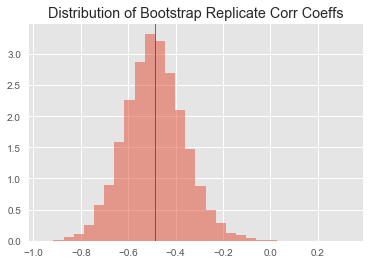

95% Confidence Interval: [-0.72886761 -0.23087434]


In [1063]:
plt.hist(bs_replicates, bins = 30, normed = True, alpha = .5)
plt.axvline(x = (np.corrcoef(x = tn_state_df.dropna()['eviction-rate'],
                             y = tn_state_df.dropna()['poverty-rate'])[0][1]),
                color = 'red', linewidth = .8)
plt.title('Distribution of Bootstrap Replicate Corr Coeffs')
plt.show()
print('95% Confidence Interval:', np.percentile(bs_replicates, [2.5, 97.5]))

### State Level Correlation Coefficient During Census Years 95% Confidence interval

In [1094]:
# for 1,000 simulated samples
bs_replicates = np.empty(10000)
for i in range(10000):
    # get indices of the empirical data
    inds = list(tn_state_df[tn_census_years].dropna()['eviction-rate'].index)
    
    # get random selection of the indices (note: "double-dipping" is allowed)
    bs_inds = np.random.choice(inds, len(inds))
    
    # get the randomly sampled data pairs
    bs_ev_rate = tn_state_df[tn_census_years].dropna()['eviction-rate'][bs_inds]
    bs_pv_rate = tn_state_df[tn_census_years].dropna()['poverty-rate'][bs_inds]
    
    # get the 
    bs_replicates[i] = np.corrcoef(x = bs_ev_rate, y = bs_pv_rate)[0][1]

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3183: RuntimeWarning:

invalid value encountered in true_divide



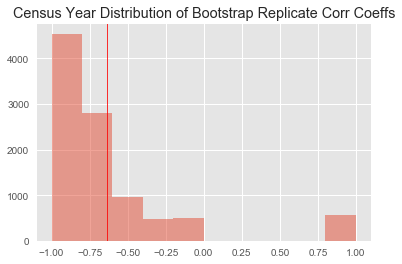

95% Confidence Interval: [-1.  1.]
90% Confidence Interval: [-1.  1.]
80% Confidence Interval: [-1.         -0.16338363]
70% Confidence Interval: [-1.         -0.38809754]


In [1098]:

plt.hist(bs_replicates[~np.isnan(bs_replicates)], 
         #bins = 30, 
         #density = True, 
         alpha = .5)
plt.axvline(x = (np.corrcoef(x = tn_state_df[tn_census_years].dropna()['eviction-rate'],
                             y = tn_state_df[tn_census_years].dropna()['poverty-rate'])[0][1]),
                color = 'red', linewidth = .8)
plt.title('Census Year Distribution of Bootstrap Replicate Corr Coeffs')
plt.show()

print('95% Confidence Interval:', np.percentile(bs_replicates[~np.isnan(bs_replicates)],
                                                [2.5, 97.5]))
print('90% Confidence Interval:', np.percentile(bs_replicates[~np.isnan(bs_replicates)],
                                                [5, 95]))
print('80% Confidence Interval:', np.percentile(bs_replicates[~np.isnan(bs_replicates)],
                                                [10, 90]))
print('70% Confidence Interval:', np.percentile(bs_replicates[~np.isnan(bs_replicates)],
                                                [15, 85]))

## This will require some further research on how to handle this asymetric bootstrap distribution. 
- I'm guessing I probably don't have enough data here
- internet says a t-statistic or t-test will be more accurte in cases where the sample size is small
**But Ultimately, It might end up being a moot point if I can circumvent the issue by using the county instead of the state data.** The county data has a much larger sample.

### County Level Correlations of Evictions and Filings on Poverty

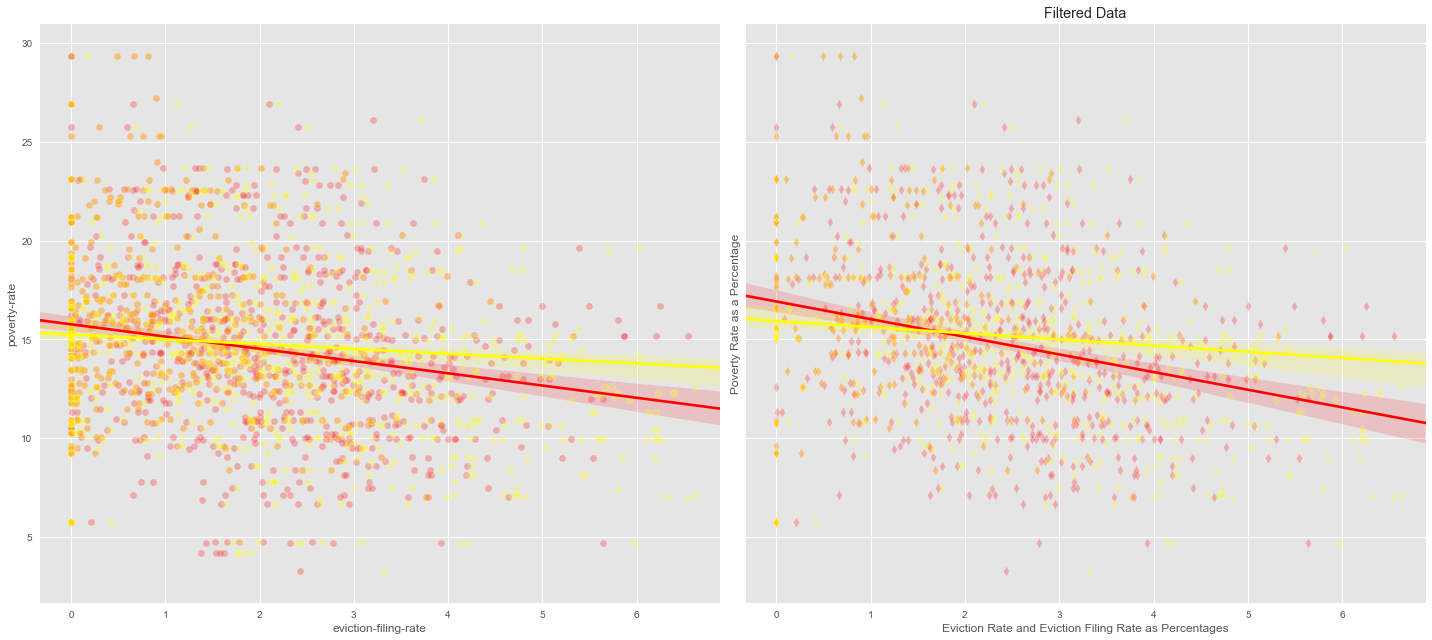

In [713]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey = True, figsize = (20, 9))

# add unfiltered linear regression to axis 1
sns.regplot(y = counties_evicts_df['poverty-rate'],
           x = counties_evicts_df['eviction-rate'],
            robust = True,
           color = 'red', marker = 'o', scatter_kws = {'alpha':'.25', 
                                            'edgecolors':'white',
                                           'linewidths':'.5'},
           ax = ax1)
sns.regplot(x = counties_evicts_df['eviction-filing-rate'],
           y = counties_evicts_df['poverty-rate'],
           robust = True,
           color = 'yellow', marker = 'o', scatter_kws = {'alpha': '.25',
                                                         'edgecolors': 'white',
                                                         'linewidths': '.5'},
            line_kws = {'linestyle':'-'}, 
           ax = ax1)
plt.title('Unfiltered Data')
plt.xlabel('Eviction Rate and Eviction Filing Rate as Percentages')
plt.ylabel('Poverty Rate as a Percentage')

# add filtered regression to axis 2
sns.regplot(y = counties_evicts_df['poverty-rate'][counties_evicts_df['low-flag'] == 0],
           x = counties_evicts_df['eviction-rate'][counties_evicts_df['low-flag'] == 0],
            robust = True,
           color = 'red', marker = 'd', scatter_kws = {'alpha':'.25', 
                                            'edgecolors':'white',
                                           'linewidths':'.5'},
           ax = ax2)
sns.regplot(x = counties_evicts_df['eviction-filing-rate'][counties_evicts_df['low-flag'] == 0],
           y = counties_evicts_df['poverty-rate'][counties_evicts_df['low-flag'] == 0],
           robust = True,
           color = 'yellow', marker = 'd', scatter_kws = {'alpha': '.25',
                                                         'edgecolors': 'white',
                                                         'linewidths': '.5'},
            line_kws = {'linestyle':'-'}, 
           ax = ax2)

plt.title('Filtered Data')
plt.xlabel('Eviction Rate and Eviction Filing Rate as Percentages')
plt.ylabel('Poverty Rate as a Percentage')

#plt.show()
f.tight_layout()

**But the above regression combines yearly vs periodically collected data.** Such that between censuses the poverty data is portrayed comepletely insensitive to changes in anual metrics. 
### How do these correlations change when we only use years where both metrics were measured?
i.e. 2000, 2005, 2010, 2011

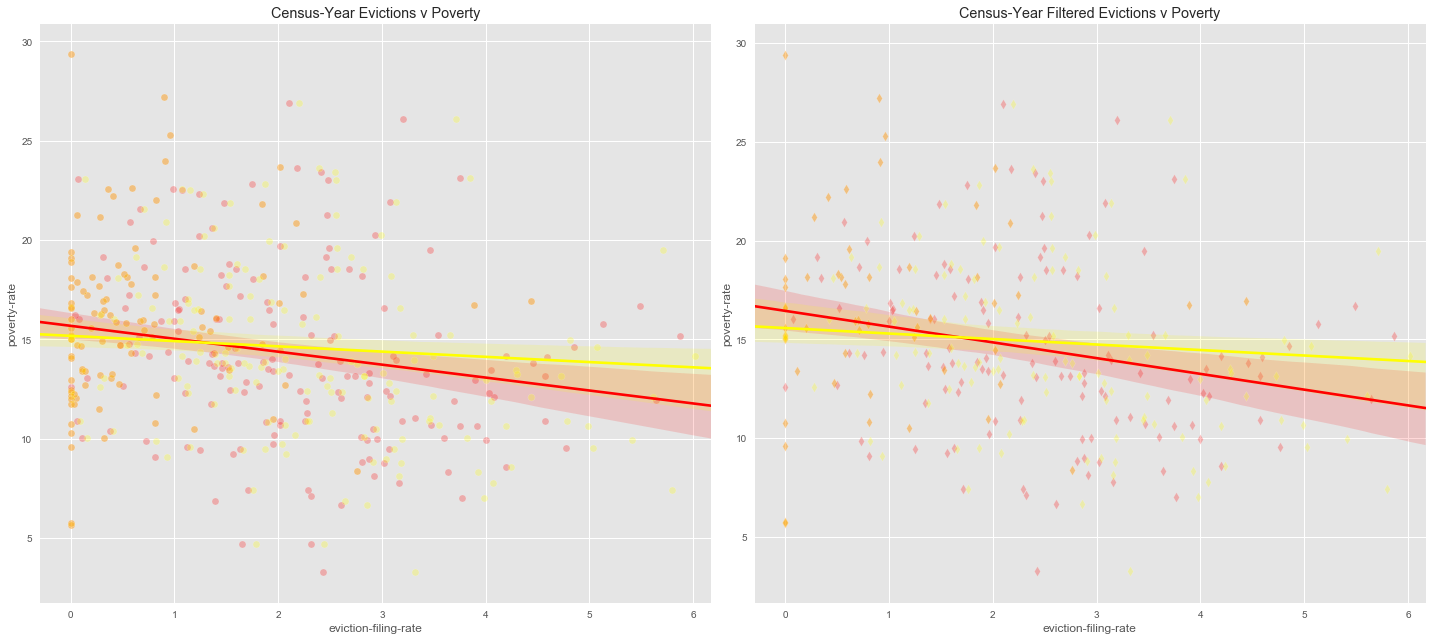

In [1043]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey = False, figsize = (20, 9))

# add unfiltered linear regression to axis 1
sns.regplot(y = counties_evicts_df[census_years]['poverty-rate'],
           x = counties_evicts_df[census_years]['eviction-rate'],
            robust = True,
           color = 'red', marker = 'o', scatter_kws = {'alpha':'.25', 
                                            'edgecolors':'white',
                                           'linewidths':'.5'},
           ax = ax1)
sns.regplot(x = counties_evicts_df[census_years]['eviction-filing-rate'],
           y = counties_evicts_df[census_years]['poverty-rate'],
           robust = True,
           color = 'yellow', marker = 'o', scatter_kws = {'alpha': '.25',
                                                         'edgecolors': 'white',
                                                         'linewidths': '.5'},
            line_kws = {'linestyle':'-'}, 
           ax = ax1)
ax1.set_title('Census-Year Evictions v Poverty')


# add filtered regression to axis 2
sns.regplot(y = counties_evicts_df[census_years]['poverty-rate'][counties_evicts_df['low-flag'] == 0],
           x = counties_evicts_df[census_years]['eviction-rate'][counties_evicts_df['low-flag'] == 0],
            robust = True,
           color = 'red', marker = 'd', scatter_kws = {'alpha':'.25', 
                                            'edgecolors':'white',
                                           'linewidths':'.5'},
           ax = ax2)
sns.regplot(x = counties_evicts_df[census_years]['eviction-filing-rate'][counties_evicts_df['low-flag'] == 0],
           y = counties_evicts_df[census_years]['poverty-rate'][counties_evicts_df['low-flag'] == 0],
           robust = True,
           color = 'yellow', marker = 'd', scatter_kws = {'alpha': '.25',
                                                         'edgecolors': 'white',
                                                         'linewidths': '.5'},
            line_kws = {'linestyle':'-'}, 
           ax = ax2)
ax2.set_title('Census-Year Filtered Evictions v Poverty')

f.tight_layout()
plt.show()

##### Hmmm.... Looks about the same. I guess there was no need to plot it, especially since my eyes can't judge the coefficient with sufficient accuracy. 
### Compare correlation coefficients in general vs census years:


In [741]:
print('State-Level Correlation Coefficient During Census Years:')
print(np.corrcoef(x = tn_state_df[tn_census_years].dropna()['eviction-rate'],
           y = tn_state_df[tn_census_years].dropna()['poverty-rate'])[0][1])
print("")
print('State-Level Correlation Coefficient Across all Years:')
print(np.corrcoef(x = tn_state_df.dropna()['eviction-rate'],
           y = tn_state_df.dropna()['poverty-rate'])[0][1])
print('==='*30)

print('Unfiltered County-Level Correlation Coefficient During Census Years:')
print(np.corrcoef(x = counties_evicts_df[census_years].dropna()['eviction-rate'],
           y = counties_evicts_df[census_years].dropna()['poverty-rate'])[0][1])
print("")

print('Filtered County-Level Correlation Coefficient During Census Years:')
print(np.corrcoef(x = counties_evicts_df[census_years
                                        ][counties_evicts_df['low-flag'] == 0
                                         ].dropna()['eviction-rate'],
           y = counties_evicts_df[census_years
                                 ][counties_evicts_df['low-flag'] == 0
                                  ].dropna()['poverty-rate'])[0][1])
print("")
print('Unfilterd County-Level Correlation Coefficient Across all Years:')
print(np.corrcoef(x = counties_evicts_df.dropna()['eviction-rate'],
           y = counties_evicts_df.dropna()['poverty-rate'])[0][1])
print('')
print('Filtered County-Level Correlation Coefficient Across all Years:')
print(np.corrcoef(x = counties_evicts_df[counties_evicts_df['low-flag'] == 0].dropna()['eviction-rate'],
           y = counties_evicts_df[counties_evicts_df['low-flag'] == 0].dropna()['poverty-rate'])[0][1])
print('')

State-Level Correlation Coefficient During Census Years:
-0.6352349962365619

State-Level Correlation Coefficient Across all Years:
-0.48792367515603374
Unfiltered County-Level Correlation Coefficient During Census Years:
-0.1952692614777052

Filtered County-Level Correlation Coefficient During Census Years:
-0.22879483688878632

Unfilterd County-Level Correlation Coefficient Across all Years:
-0.20680714792812885

Filtered County-Level Correlation Coefficient Across all Years:
-0.27526401597359224



/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



### Observations:
At the State Level:
- Strongest correlation observed at the state level, using only census years (i.e. 2000, 2005, 2010, 2011)
- The correlation drops by about a tenth when non-census years are included. Suggesting that the unreciprocated measurements are watering down the correlation.

At the County Level of Granularity:
- The correlations are much weaker, with filtering by low-flag and census year increasing the magnitude of the correlation
    - **perhaps the variance across counties is watering down the correlation**

## I.C) Which Counties had the strongest and weakest correlation coefficients between evictions, filings and poverty?
- A. We can measure this correlation for the 16 years of each county
- B. We can get much more granular by using the census tracts within each county

#### read in and preprocess county level coeficient data

In [890]:
county_correlations_df = pd.DataFrame(data = list(set(counties_evicts_df.name)), 
                                      index=range(len(set(counties_evicts_df.name))),
                                     columns = ['county'])

county_correlations_df['pov-evic-corr'] = np.nan
county_correlations_df['tract-pov-evic-corr'] = np.nan
county_correlations_df['pov-filing-corr'] = np.nan
county_correlations_df['tract-pov-filing-corr'] = np.nan
#county_correlations_df[['pov-evic-corr', 'tract-pov-evic-corr', 'pov-filing-corr',
#       'tract-pov-filing-corr']] = 
county_correlations_df.head(3)


county  pov-evic-corr  tract-pov-evic-corr  pov-filing-corr  \
0     Overton County            NaN                  NaN              NaN   
1  Montgomery County            NaN                  NaN              NaN   
2       Moore County            NaN                  NaN              NaN   

   tract-pov-filing-corr  
0                    NaN  
1                    NaN  
2                    NaN

In [891]:
census_tracts_df = pd.read_csv('data/tracts.csv')
census_tracts_df.head(3)

GEOID  year   name             parent-location  population  \
0  47001020100  2000  201.0  Anderson County, Tennessee      2463.0   
1  47001020100  2001  201.0  Anderson County, Tennessee      2463.0   
2  47001020100  2002  201.0  Anderson County, Tennessee      2463.0   

   poverty-rate  pct-renter-occupied  median-gross-rent  \
0         15.14                66.67             426.61   
1         15.14                66.67             426.61   
2         15.14                66.67             426.61   

   median-household-income  median-property-value   ...    pct-multiple  \
0                 27250.48               91901.49   ...            2.31   
1                 27250.48               91901.49   ...            2.31   
2                 27250.48               91901.49   ...            2.31   

   pct-other  renter-occupied-households  eviction-filings  evictions  \
0        0.2                       831.0              16.0       13.0   
1        0.2                       864.0              16.0       13.0   
2        0.2                       896.0              12.0       10.0   

   eviction-rate  eviction-filing-rate  low-flag  imputed  subbed  
0           1.56                  1.93         0        0       1  
1           1.51                  1.85         0        0       1  
2           1.12                  1.34         0        0       1  

[3 rows x 27 columns]

In [892]:
for cty in set(census_tracts_df['parent-location']):
    if 'Tennessee' not in cty:
        print(cty)
        print('-', re.sub(',.*', '', cty))
        print('--', re.sub(',.*', '', cty) in list(set(counties_evicts_df.name)))
        print("")

Allen County, Kentucky
- Allen County
-- False

Fannin County, Georgia
- Fannin County
-- False

Mississippi County, Arkansas
- Mississippi County
-- False

Todd County, Kentucky
- Todd County
-- False

Haywood County, North Carolina
- Haywood County
-- True



drop all of these rows from census_tracts_df

In [893]:
census_tracts_df = census_tracts_df[['Tennessee' in cty for cty in census_tracts_df['parent-location']]]

In [894]:
tally = 0
for cty in set(census_tracts_df['parent-location']):
    if 'Tennessee' not in cty:
        print(cty)
        print('-', re.sub(',.*', '', cty))
        print('--', re.sub(',.*', '', cty) in list(set(counties_evicts_df.name)))
        print("")
        tally =+ 1
if tally == 0:
    print('Good to go, successfully removed all non-tn counties.')

Good to go, successfully removed all non-tn counties.


In [895]:
# assert that I can match the county names with parent-locations using some python magic
for name in counties_evicts_df.name.unique():
    assert str(name + ', Tennessee') in list(set(census_tracts_df['parent-location']))

In [896]:
round(np.corrcoef(
        x = counties_evicts_df[counties_evicts_df.name == 'Davidson County'].dropna()['eviction-rate'],
        y = counties_evicts_df[counties_evicts_df.name == 'Davidson County'].dropna()['poverty-rate']
    )[0][1], 4)

-0.271

In [897]:
type(np.corrcoef(
        x = counties_evicts_df[counties_evicts_df.name == 'Davidson County'].dropna()['eviction-rate'],
        y = counties_evicts_df[counties_evicts_df.name == 'Davidson County'].dropna()['poverty-rate']
    )[0][1])

numpy.float64

In [898]:
for i, county in zip(range(len(county_correlations_df.county)), county_correlations_df.county):
    #print(county)
    county_correlations_df['pov-evic-corr'][i] = np.corrcoef(
        x = counties_evicts_df[counties_evicts_df.name == county].dropna()['eviction-rate'],
        y = counties_evicts_df[counties_evicts_df.name == county].dropna()['poverty-rate']
    )[0][1]
    county_correlations_df['tract-pov-evic-corr'][i] = np.corrcoef(
        x = census_tracts_df[census_tracts_df['parent-location'] == str(county + ', Tennessee')].dropna()['eviction-rate'],
        y = census_tracts_df[census_tracts_df['parent-location'] == str(county + ', Tennessee')].dropna()['poverty-rate']
    )[0][1]
    county_correlations_df['pov-filing-corr'][i] = np.corrcoef(
        x = counties_evicts_df[counties_evicts_df.name == county].dropna()['eviction-filing-rate'],
        y = counties_evicts_df[counties_evicts_df.name == county].dropna()['poverty-rate']
    )[0][1]
    county_correlations_df['tract-pov-filing-corr'][i] = np.corrcoef(
        x = census_tracts_df[census_tracts_df['parent-location'] == str(county + ', Tennessee')].dropna()['eviction-filing-rate'],
        y = census_tracts_df[census_tracts_df['parent-location'] == str(county + ', Tennessee')].dropna()['poverty-rate']
    )[0][1]

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3183: RuntimeWarning:

invalid value encountered in true_divide

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3184: RuntimeWarning:

invalid value encountered in true_divide

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:1128: RuntimeWarning:

Mean of empty slice.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:73: RuntimeWarning:

invalid value encountered in true_divide

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3175: RuntimeWarning:

Degrees of freedom <= 0 for slice

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning:

divide by zero encountered in double_scalars

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning:

invalid value 

In [899]:
county_correlations_df.head()

county  pov-evic-corr  tract-pov-evic-corr  pov-filing-corr  \
0     Overton County       0.199562            -0.220604         0.067074   
1  Montgomery County      -0.216227            -0.017844         0.461114   
2       Moore County       0.558533             0.279910         0.546522   
3       Macon County      -0.584097             0.238722        -0.599422   
4     Hawkins County      -0.146741             0.022558        -0.102303   

   tract-pov-filing-corr  
0              -0.193783  
1              -0.009508  
2               0.279910  
3               0.224537  
4               0.157195

In [900]:
county_correlations_df.sort_values(by = 'pov-evic-corr').head()

county  pov-evic-corr  tract-pov-evic-corr  pov-filing-corr  \
51    Dickson County      -0.827029            -0.053962        -0.613073   
17  Henderson County      -0.792177            -0.236546        -0.795449   
90   Campbell County      -0.767627            -0.257288        -0.613855   
42    Johnson County      -0.706232             0.199821        -0.752313   
64      Meigs County      -0.674216             0.456861        -0.617822   

    tract-pov-filing-corr  
51               0.003638  
17              -0.239623  
90              -0.213287  
42               0.232964  
64               0.422728

In [901]:
county_correlations_df.sort_values(by = 'pov-evic-corr').dropna().tail()

county  pov-evic-corr  tract-pov-evic-corr  pov-filing-corr  \
67    Carter County       0.674506             0.192184         0.693514   
33     Henry County       0.677487             0.441488         0.661648   
15  Franklin County       0.719736             0.244552         0.626541   
26   Houston County       0.745211             0.257511         0.756512   
30   Lincoln County       0.777875             0.374230         0.762253   

    tract-pov-filing-corr  
67               0.238239  
33               0.436622  
15               0.249452  
26               0.223932  
30               0.419878

### Let's look at a histogram of these correlation coefficients

Histograms of county correlation coefficients


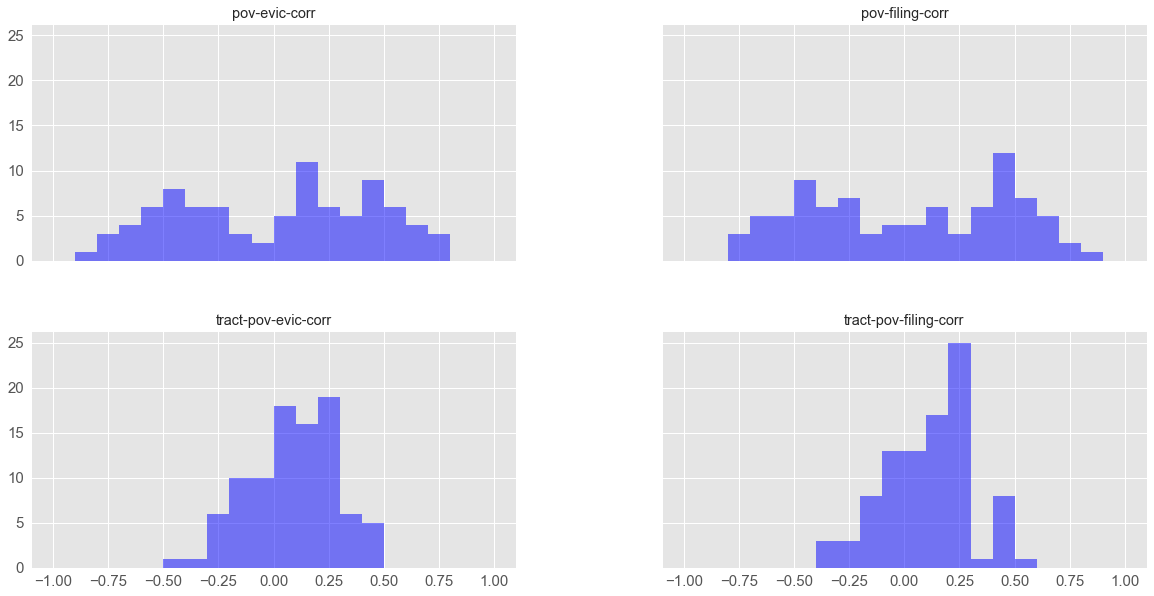

In [902]:
print('Histograms of county correlation coefficients')
county_correlations_df.hist(alpha = .5, sharex= True, sharey= True, 
                            figsize= (20, 10), xlabelsize = 15, ylabelsize = 15, 
                            range = (-1, 1), bins = 20, color = 'blue'
                           )
plt.show()

### Let's look at a histogram of the magnitudes of the correlation coefficients

Histogram of Magnitudes of Corr. Coeff.


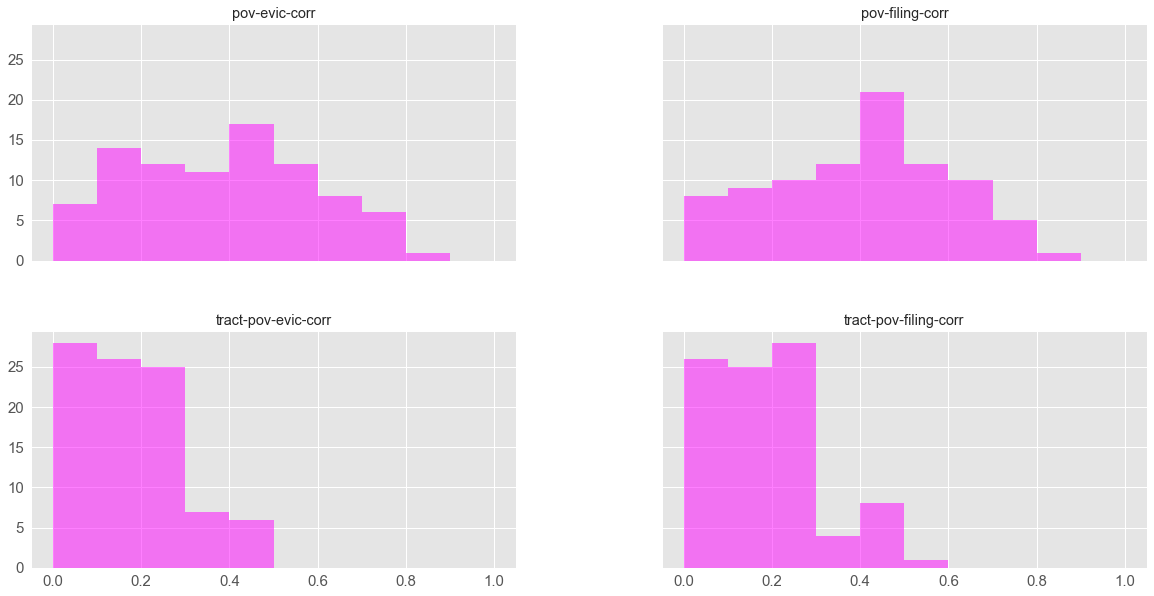

In [903]:
print('Histogram of Magnitudes of Corr. Coeff.')
county_correlations_df[['pov-evic-corr', 'tract-pov-evic-corr', 'pov-filing-corr',
       'tract-pov-filing-corr']].apply(abs).hist(alpha = .5, sharex= True, sharey= True, 
                            figsize= (20, 10), xlabelsize = 15, ylabelsize = 15, 
                            range = (0, 1), bins = 10, color = 'magenta'
                           )
plt.show()

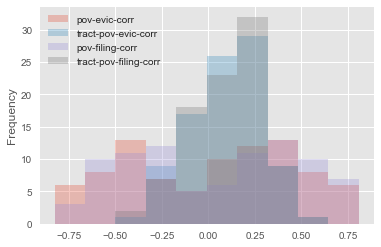

In [904]:
county_correlations_df.plot(kind = 'hist', alpha = 0.3)
plt.show()

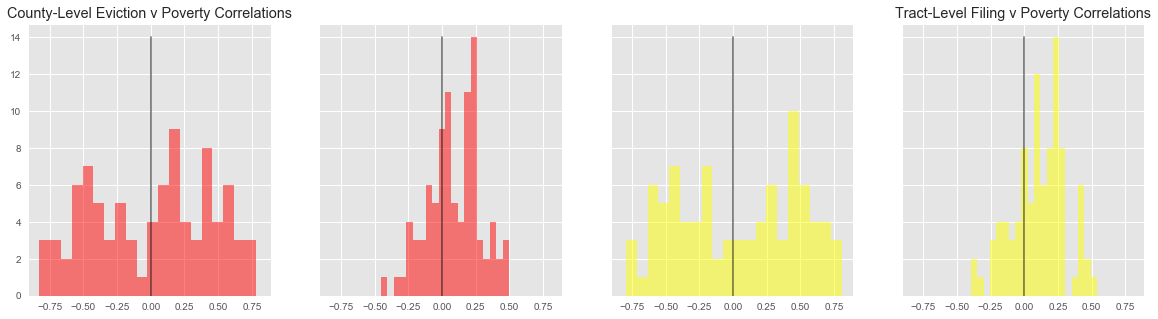

In [1002]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey = True, sharex= True,
                                       figsize = (20, 5))
ax1.hist([v for v in county_correlations_df['pov-evic-corr'].dropna()], 
         alpha = .5, bins = 20, color = 'red'
        )
ax1.plot([0, 0], [0, 14], 'black', alpha = 0.5)
ax1.set_title('County-Level Eviction v Poverty Correlations')

ax2.hist([v for v in county_correlations_df['tract-pov-evic-corr'].dropna()], 
         alpha = .5, bins = 20, color = 'red'
        )
ax2.plot([0, 0], [0, 14], 'black', alpha = 0.5)

ax3.hist([v for v in county_correlations_df['pov-filing-corr'].dropna()], 
         alpha = .5, bins = 20, color = 'yellow'
        )
ax3.plot([0, 0], [0, 14], 'black', alpha = 0.5)

ax4.hist([v for v in county_correlations_df['tract-pov-filing-corr'].dropna()], 
         alpha = .5, bins = 20, color = 'yellow'
        )
ax4.plot([0, 0], [0, 14], 'black', alpha = 0.5)
ax4.set_title('Tract-Level Filing v Poverty Correlations')

plt.show()

**Initial Observations**
- There are more stronger (or significant) when a county's coefficient is calculated at the county level across 16 years. 
    - there are virtually no coefficients of magnitude greater than .5 when they are calculated at the census tract level. 
    - *What might explain this?*
        - would have to look into how the census tract level data was produced
- There are a significant number of counties with coefficients of magnitude greater than .5
    - exactly how many?

### What does the distribution of coefficients look like for the filtered data?

In [906]:
county_correlations_df['filtered-pec'] = np.nan
county_correlations_df['filtered-tpec'] = np.nan
county_correlations_df['filtered-pfc'] = np.nan
county_correlations_df['filtered-tpfc'] = np.nan

⚠️ Before I run the loop below to assign the values I'm going to have to fix the flags in the tracts df

In [907]:
for col in ['low-flag', 'imputed', 'subbed']:
    print(col, 'sum:', census_tracts_df[col].sum(), 'pct:', round(100*census_tracts_df[col].sum()/len(census_tracts_df), 2))

low-flag sum: 736 pct: 2.9
imputed sum: 0 pct: 0.0
subbed sum: 4391 pct: 17.29


Are the flag columns names in the same order as in the:
- tn data
- corrected county data

In [908]:
tn_state_df.head(1)

GEOID  year       name parent-location  population  poverty-rate  \
0     47  2000  Tennessee             USA   5689283.0         13.48   

   pct-renter-occupied  median-gross-rent  median-household-income  \
0                30.07              505.0                  36360.0   

   median-property-value   ...    pct-multiple  pct-other  \
0                93000.0   ...            0.96       0.08   

   renter-occupied-households  eviction-filings  evictions  eviction-rate  \
0                    216654.0            4327.0     4012.0           1.85   

   eviction-filing-rate  low-flag  imputed  subbed  
0                   2.0         1        0       0  

[1 rows x 27 columns]

In [909]:
census_tracts_df.head(1)

GEOID  year   name             parent-location  population  \
0  47001020100  2000  201.0  Anderson County, Tennessee      2463.0   

   poverty-rate  pct-renter-occupied  median-gross-rent  \
0         15.14                66.67             426.61   

   median-household-income  median-property-value   ...    pct-multiple  \
0                 27250.48               91901.49   ...            2.31   

   pct-other  renter-occupied-households  eviction-filings  evictions  \
0        0.2                       831.0              16.0       13.0   

   eviction-rate  eviction-filing-rate  low-flag  imputed  subbed  
0           1.56                  1.93         0        0       1  

[1 rows x 27 columns]

In [910]:
counties_evicts_df.head(1)

GEOID  year             name parent-location  population  poverty-rate  \
0  47001  2000  Anderson County       Tennessee     71330.0         13.14   

   pct-renter-occupied  median-gross-rent  median-household-income  \
0                27.49              450.0                  35483.0   

   median-property-value    ...     pct-multiple  pct-other  \
0                87500.0    ...             1.14       0.07   

   renter-occupied-households  eviction-filings  evictions  eviction-rate  \
0                      8189.0             125.0      118.0           1.44   

   eviction-filing-rate  imputed  subbed  low-flag  
0                  1.53        0       0         1  

[1 rows x 27 columns]

They are in the same position as the tn data but not as the fixed county level data.
- So still an open question if the mislabeling of these columns persists

If the tract flag columns are labeled correctly then every county with a low flag in the tracts data should also be flagged low in the fixed county data and vice versa.

**If the flag columns are mislabeled in the tract data then every county with a subbed flag in the tracts data should also have a low flag in the fixed county data and vice versa**

In [911]:
low_tract_counties = list(set(census_tracts_df['parent-location'][census_tracts_df['low-flag'] == 1]))
print(len(low_tract_counties))
sorted(low_tract_counties)

20


['Anderson County, Tennessee',
 'Bradley County, Tennessee',
 'Carter County, Tennessee',
 'Cocke County, Tennessee',
 'Dickson County, Tennessee',
 'Dyer County, Tennessee',
 'Franklin County, Tennessee',
 'Gibson County, Tennessee',
 'Hamilton County, Tennessee',
 'Hancock County, Tennessee',
 'Hawkins County, Tennessee',
 'Henderson County, Tennessee',
 'Knox County, Tennessee',
 'Putnam County, Tennessee',
 'Rhea County, Tennessee',
 'Sullivan County, Tennessee',
 'Sumner County, Tennessee',
 'Weakley County, Tennessee',
 'White County, Tennessee',
 'Wilson County, Tennessee']

In [912]:
low_counties = list(set(counties_evicts_df.name[counties_evicts_df['low-flag'] == 1]))
print(len(low_counties))
#sorted(low_counties)

58


In [913]:
subbed_tract_counties = list(set(census_tracts_df['parent-location'][census_tracts_df['subbed'] == 1]))
print(len(subbed_tract_counties))
#sorted(subbed_tract_counties)

63


In [914]:
imputed_tract_counties = list(set(census_tracts_df['parent-location'][census_tracts_df['imputed'] == 1]))
print(len(imputed_tract_counties))
sorted(imputed_tract_counties)

0


[]

Clearly we have a count mismatch between the low-flag and subbed columns. There are only 20 tract-counties flagged as low but 58 counties flagged as low.
- Furthermore, the proximity in count of the 'subbed' tract-counties to the low flagged counties suggests the error persists

let's test to see if tract-counties flagged as subbed but not as low counties have a significantly low proportion fo tracts flagged. 
- presumably county would also only be flagged as low if a majority of their tracts were flagged as low

In [915]:
for cty in subbed_tract_counties:
    #print(cty)
    if re.sub(', Tennessee', '', cty) not in low_counties:
        print(cty, 'has ',  len(census_tracts_df[census_tracts_df['parent-location'] == cty]), 'tracts')
        print(' - of which: ', census_tracts_df[census_tracts_df['parent-location'] == cty]['subbed'].sum(), 'are subbed tracts')
        print('thats', round(100*census_tracts_df[census_tracts_df['parent-location'] == cty]['subbed'].sum()/len(census_tracts_df[census_tracts_df['parent-location'] == cty]), 2), '%')
        print('')

Campbell County, Tennessee has  207 tracts
 - of which:  14 are subbed tracts
thats 6.76 %

Carter County, Tennessee has  299 tracts
 - of which:  2 are subbed tracts
thats 0.67 %

Loudon County, Tennessee has  210 tracts
 - of which:  3 are subbed tracts
thats 1.43 %

Bedford County, Tennessee has  183 tracts
 - of which:  10 are subbed tracts
thats 5.46 %

Davidson County, Tennessee has  2747 tracts
 - of which:  10 are subbed tracts
thats 0.36 %



**This confirms the flag columns are also mislabeled in the tract data**
- so fix the labels and move on with life

I suppose I could alert EL about the persistence of this error 🙄 

In [916]:
census_tracts_df.rename(columns = {'low-flag': 'imputed',
                                    'imputed': 'subbed',
                                    'subbed': 'low-flag'}, inplace = True)

In [917]:
county_correlations_df.head()

county  pov-evic-corr  tract-pov-evic-corr  pov-filing-corr  \
0     Overton County       0.199562            -0.220604         0.067074   
1  Montgomery County      -0.216227            -0.017844         0.461114   
2       Moore County       0.558533             0.279910         0.546522   
3       Macon County      -0.584097             0.238722        -0.599422   
4     Hawkins County      -0.146741             0.022558        -0.102303   

   tract-pov-filing-corr  filtered-pec  filtered-tpec  filtered-pfc  \
0              -0.193783           NaN            NaN           NaN   
1              -0.009508           NaN            NaN           NaN   
2               0.279910           NaN            NaN           NaN   
3               0.224537           NaN            NaN           NaN   
4               0.157195           NaN            NaN           NaN   

   filtered-tpfc  
0            NaN  
1            NaN  
2            NaN  
3            NaN  
4            NaN

## Add filtered coefficient measurements to each county

In [918]:
county_correlations_df['filtered-pec'] = np.nan
county_correlations_df['filtered-tpec'] = np.nan
county_correlations_df['filtered-fpc'] = np.nan
county_correlations_df['filtered-tfpc'] = np.nan

In [919]:
for i, county in zip(range(len(county_correlations_df.county)), county_correlations_df.county):
    #print(county)
    county_correlations_df['filtered-pec'][i] = np.corrcoef(
        x = counties_evicts_df[counties_evicts_df.name == county][counties_evicts_df['low-flag'] == 0].dropna()['eviction-rate'],
        y = counties_evicts_df[counties_evicts_df.name == county]
                              [counties_evicts_df['low-flag'] == 0].dropna()['poverty-rate']
    )[0][1]
    county_correlations_df['filtered-tpec'][i] = np.corrcoef(
        x = census_tracts_df[census_tracts_df['parent-location'] == str(county + ', Tennessee')][census_tracts_df['low-flag'] == 0].dropna()['eviction-rate'],
        y = census_tracts_df[census_tracts_df['parent-location'] == str(county + ', Tennessee')][census_tracts_df['low-flag'] == 0].dropna()['poverty-rate']
    )[0][1]
    county_correlations_df['filtered-fpc'][i] = np.corrcoef(
        x = counties_evicts_df[counties_evicts_df.name == county][counties_evicts_df['low-flag'] == 0].dropna()['eviction-filing-rate'],
        y = counties_evicts_df[counties_evicts_df.name == county][counties_evicts_df['low-flag'] == 0].dropna()['poverty-rate']
    )[0][1]
    county_correlations_df['filtered-tfpc'][i] = np.corrcoef(
        x = census_tracts_df[census_tracts_df['parent-location'] == str(county + ', Tennessee')][census_tracts_df['low-flag'] == 0].dropna()['eviction-filing-rate'],
        y = census_tracts_df[census_tracts_df['parent-location'] == str(county + ', Tennessee')][census_tracts_df['low-flag'] == 0].dropna()['poverty-rate']
    )[0][1]

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anac

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/ana

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anac

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/ana

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/an

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anac

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/ana

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anac

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anac

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anac

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/an

In [920]:
county_correlations_df.columns

Index(['county', 'pov-evic-corr', 'tract-pov-evic-corr', 'pov-filing-corr',
       'tract-pov-filing-corr', 'filtered-pec', 'filtered-tpec',
       'filtered-pfc', 'filtered-tpfc', 'filtered-fpc', 'filtered-tfpc'],
      dtype='object')

In [922]:
county_correlations_df = county_correlations_df[['county', 
                        'pov-evic-corr', 'tract-pov-evic-corr', 'filtered-pec', 'filtered-tpec',
                        'pov-filing-corr','tract-pov-filing-corr','filtered-fpc', 'filtered-tfpc']]

In [923]:
county_correlations_df.head()

county  pov-evic-corr  tract-pov-evic-corr  filtered-pec  \
0     Overton County       0.199562            -0.220604      0.758094   
1  Montgomery County      -0.216227            -0.017844     -0.216227   
2       Moore County       0.558533             0.279910      0.558533   
3       Macon County      -0.584097             0.238722     -0.584097   
4     Hawkins County      -0.146741             0.022558     -0.146741   

   filtered-tpec  pov-filing-corr  tract-pov-filing-corr  filtered-fpc  \
0      -0.345126         0.067074              -0.193783      0.644778   
1      -0.017844         0.461114              -0.009508      0.461114   
2       0.279910         0.546522               0.279910      0.546522   
3       0.238722        -0.599422               0.224537     -0.599422   
4       0.022558        -0.102303               0.157195     -0.102303   

   filtered-tfpc  
0      -0.342371  
1      -0.009508  
2       0.279910  
3       0.224537  
4       0.157195

## Visualize distribution of (un)filtered tract and county level correlation coefficients

-------------------- Histograms of county correlation coefficients --------------------


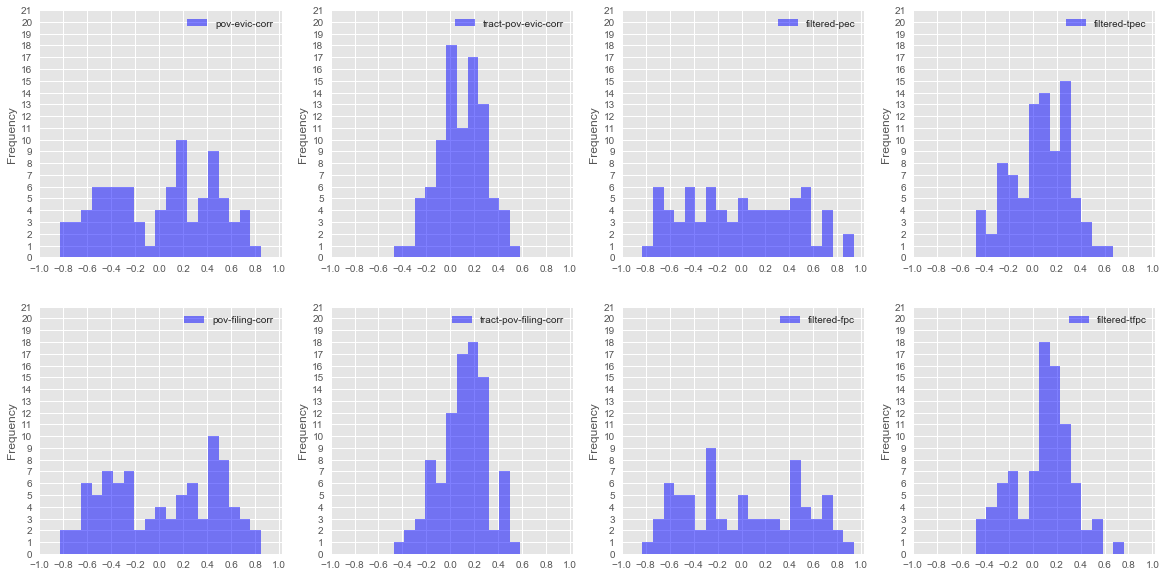

In [924]:
print('-'*20, 'Histograms of county correlation coefficients', '-'*20)
county_correlations_df.plot(subplots = True, layout = (2, 4),
                            kind = 'hist', 
                            alpha = .5, 
                            sharex= False, sharey= False, 
                            figsize= (20, 10), 
                            xticks = np.arange(-1, 1.2, .2), yticks = np.arange(0, 22, 1),
                            #xlabelsize = 15, ylabelsize = 15, 
                            #range = (-1, 1), 
                            bins = 20, color = 'blue'
                           )
#plt.title('Histograms of county correlation coefficients')
plt.show()

### visualize the distribution of magnitudes of correlations

Histograms of county correlation coefficients


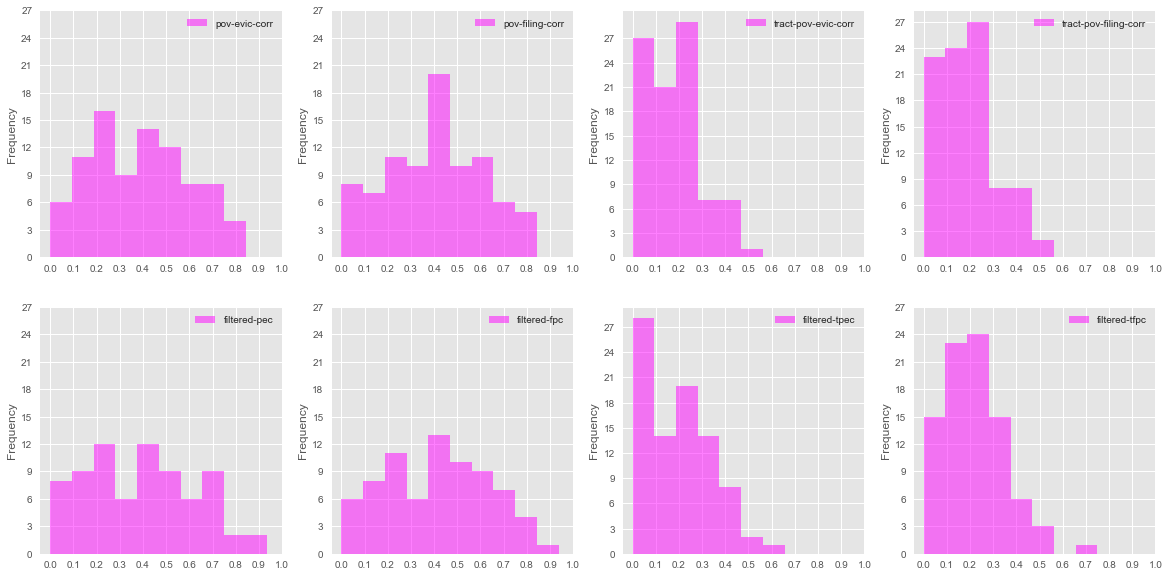

In [926]:
print('Histograms of county correlation coefficients')
county_correlations_df[['pov-evic-corr', 'pov-filing-corr', 'tract-pov-evic-corr', 'tract-pov-filing-corr',
                       'filtered-pec', 'filtered-fpc', 'filtered-tpec', 'filtered-tfpc']].apply(abs).plot(
    subplots = True, layout = (2, 4),
                            kind = 'hist', 
                            alpha = .5, 
                            sharex= False, sharey= False, 
                            figsize= (20, 10), 
                            xticks = np.arange(0, 1.1, .1), yticks = np.arange(0, 30, 3),
                            #xlabelsize = 15, ylabelsize = 15, 
                            bins = 10, color = 'magenta'
                           )
plt.show()

## Let's take a look at an illustrative example:
### Hardeman County
**Has the highest Filtered Eviction to Poverty Correlation Coefficient at 0.94**

In [927]:
county_correlations_df.sort_values(by = 'filtered-pec', ascending=False).head()

county  pov-evic-corr  tract-pov-evic-corr  filtered-pec  \
66  Hardeman County       0.490522             0.437489      0.937029   
14   Stewart County      -0.221115             0.235274      0.927578   
0    Overton County       0.199562            -0.220604      0.758094   
26   Houston County       0.745211             0.257511      0.745211   
22      Rhea County       0.390782             0.266212      0.742613   

    filtered-tpec  pov-filing-corr  tract-pov-filing-corr  filtered-fpc  \
66       0.319719         0.464207               0.424497      0.915617   
14       0.495405        -0.311374               0.252235      0.821995   
0       -0.345126         0.067074              -0.193783      0.644778   
26       0.257511         0.756512               0.223932      0.756512   
22       0.322910         0.421401               0.291048      0.788704   

    filtered-tfpc  
66       0.321426  
14       0.534143  
0       -0.342371  
26       0.223932  
22       0.369329

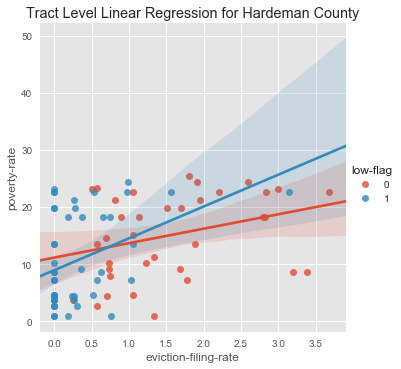

In [976]:
sns.lmplot(x = 'eviction-filing-rate',
            y = 'poverty-rate', 
            data = census_tracts_df[census_tracts_df['parent-location'] == 'Hardeman County, Tennessee'].dropna(),
           hue = 'low-flag'
           )
plt.title('Tract Level Linear Regression for Hardeman County')
plt.show()

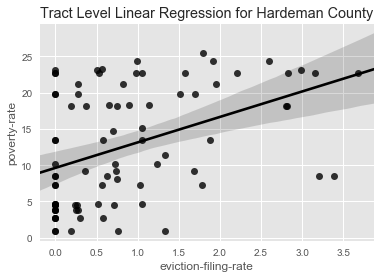

In [993]:
sns.regplot(x = 'eviction-filing-rate',
            y = 'poverty-rate', 
            data = census_tracts_df[census_tracts_df['parent-location'] == 'Hardeman County, Tennessee'].dropna(),
           #hue = 'low-flag'
           color = 'black'
           )
plt.title('Tract Level Linear Regression for Hardeman County')
plt.show()

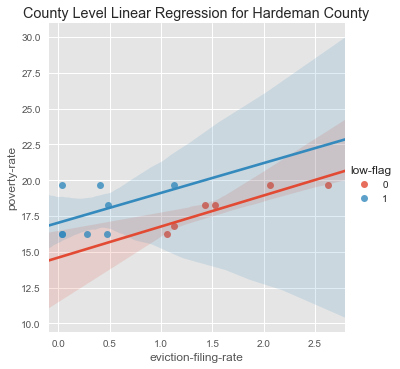

In [1041]:
sns.lmplot(x = 'eviction-filing-rate',
            y = 'poverty-rate', 
            data = counties_evicts_df[counties_evicts_df.name == 'Hardeman County'].dropna(),
           hue = 'low-flag'
           )
plt.title('County Level Linear Regression for Hardeman County')
plt.show()

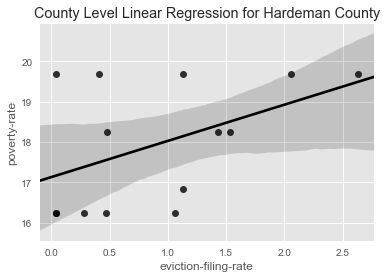

In [978]:
sns.regplot(x = 'eviction-filing-rate',
            y = 'poverty-rate', 
            data = counties_evicts_df[counties_evicts_df.name == 'Hardeman County'].dropna(),
           #hue = 'low-flag'
            color = 'black',
           )
plt.title('County Level Linear Regression for Hardeman County')
plt.show()

## generate the coefficients for census years only

In [936]:
tract_census_years = [y in [2000, 2005, 2010, 2011] for y in census_tracts_df['year']]

In [932]:
county_correlations_df['census-pec'] = np.nan
county_correlations_df['census-tpec'] = np.nan
county_correlations_df['census-filt-pec'] = np.nan
county_correlations_df['census-filt-tpec'] = np.nan
county_correlations_df['census-pfc'] = np.nan#
county_correlations_df['census-tpfc'] = np.nan#
county_correlations_df['census-filt-pfc'] = np.nan#
county_correlations_df['census-filt-tpfc'] = np.nan#

In [944]:
for i, county in zip(range(len(county_correlations_df.county)), county_correlations_df.county):
    #print(county)
    county_correlations_df['census-pec'][i] = np.corrcoef(
        x = counties_evicts_df[census_years][counties_evicts_df.name == county].dropna()['eviction-rate'],
        y = counties_evicts_df[census_years][counties_evicts_df.name == county].dropna()['poverty-rate']
    )[0][1]
    county_correlations_df['census-tpec'][i] = np.corrcoef(
        x = census_tracts_df[tract_census_years][census_tracts_df['parent-location'] == str(county + ', Tennessee')].dropna()['eviction-rate'],
        y = census_tracts_df[tract_census_years][census_tracts_df['parent-location'] == str(county + ', Tennessee')].dropna()['poverty-rate']
    )[0][1]
    county_correlations_df['census-pfc'][i] = np.corrcoef(
        x = counties_evicts_df[census_years][counties_evicts_df.name == county].dropna()['eviction-filing-rate'],
        y = counties_evicts_df[census_years][counties_evicts_df.name == county].dropna()['poverty-rate']
    )[0][1]
    county_correlations_df['census-tpfc'][i] = np.corrcoef(
        x = census_tracts_df[tract_census_years][census_tracts_df['parent-location'] == str(county + ', Tennessee')].dropna()['eviction-filing-rate'],
        y = census_tracts_df[tract_census_years][census_tracts_df['parent-location'] == str(county + ', Tennessee')].dropna()['poverty-rate']
    )[0][1]

    county_correlations_df['census-filt-pec'][i] = np.corrcoef(
        x = counties_evicts_df[census_years][counties_evicts_df.name == county][counties_evicts_df['low-flag'] == 0].dropna()['eviction-rate'],
        y = counties_evicts_df[census_years][counties_evicts_df.name == county]
                              [counties_evicts_df['low-flag'] == 0].dropna()['poverty-rate']
    )[0][1]
    county_correlations_df['census-filt-tpec'][i] = np.corrcoef(
        x = census_tracts_df[tract_census_years][census_tracts_df['parent-location'] == str(county + ', Tennessee')][census_tracts_df['low-flag'] == 0].dropna()['eviction-rate'],
        y = census_tracts_df[tract_census_years][census_tracts_df['parent-location'] == str(county + ', Tennessee')][census_tracts_df['low-flag'] == 0].dropna()['poverty-rate']
    )[0][1]
    county_correlations_df['census-filt-pfc'][i] = np.corrcoef(
        x = counties_evicts_df[census_years][counties_evicts_df.name == county][counties_evicts_df['low-flag'] == 0].dropna()['eviction-filing-rate'],
        y = counties_evicts_df[census_years][counties_evicts_df.name == county][counties_evicts_df['low-flag'] == 0].dropna()['poverty-rate']
    )[0][1]
    county_correlations_df['census-filt-tpfc'][i] = np.corrcoef(
        x = census_tracts_df[tract_census_years][census_tracts_df['parent-location'] == str(county + ', Tennessee')][census_tracts_df['low-flag'] == 0].dropna()['eviction-filing-rate'],
        y = census_tracts_df[tract_census_years][census_tracts_df['parent-location'] == str(county + ', Tennessee')][census_tracts_df['low-flag'] == 0].dropna()['poverty-rate']
    )[0][1]

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaco

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/a

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/an

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/ana

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/a

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/a

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/a

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/a

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaco

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/a

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/a

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaco

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/a

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/a

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/ana

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/a

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/an

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/ana

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/a

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/ana

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/a

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/an

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaco

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/a

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/a

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/a

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaco

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/a

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/a

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/an

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaco

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/paulomartinez/a

In [961]:
county_correlations_df.head(3)

county  pov-evic-corr  tract-pov-evic-corr  filtered-pec  \
0     Overton County       0.199562            -0.220604      0.758094   
1  Montgomery County      -0.216227            -0.017844     -0.216227   
2       Moore County       0.558533             0.279910      0.558533   

   filtered-tpec  pov-filing-corr  tract-pov-filing-corr  filtered-fpc  \
0      -0.345126         0.067074              -0.193783      0.644778   
1      -0.017844         0.461114              -0.009508      0.461114   
2       0.279910         0.546522               0.279910      0.546522   

   filtered-tfpc  census-pec  census-tpec  census-filt-pec  census-filt-tpec  \
0      -0.342371    0.375388    -0.683180              NaN         -0.251128   
1      -0.009508    1.000000     0.473708          1.00000          0.473708   
2       0.279910    0.521740          NaN          0.52174               NaN   

   census-pfc  census-tpfc  census-filt-pfc  census-filt-tpfc  
0    0.375388    -0.686488              NaN         -0.251128  
1    1.000000     0.621262          1.00000          0.621262  
2    0.521740          NaN          0.52174               NaN

## Visualize distribution of Correlation Magnitudes/Strenghts at the County Level

Histograms of county correlation coefficients


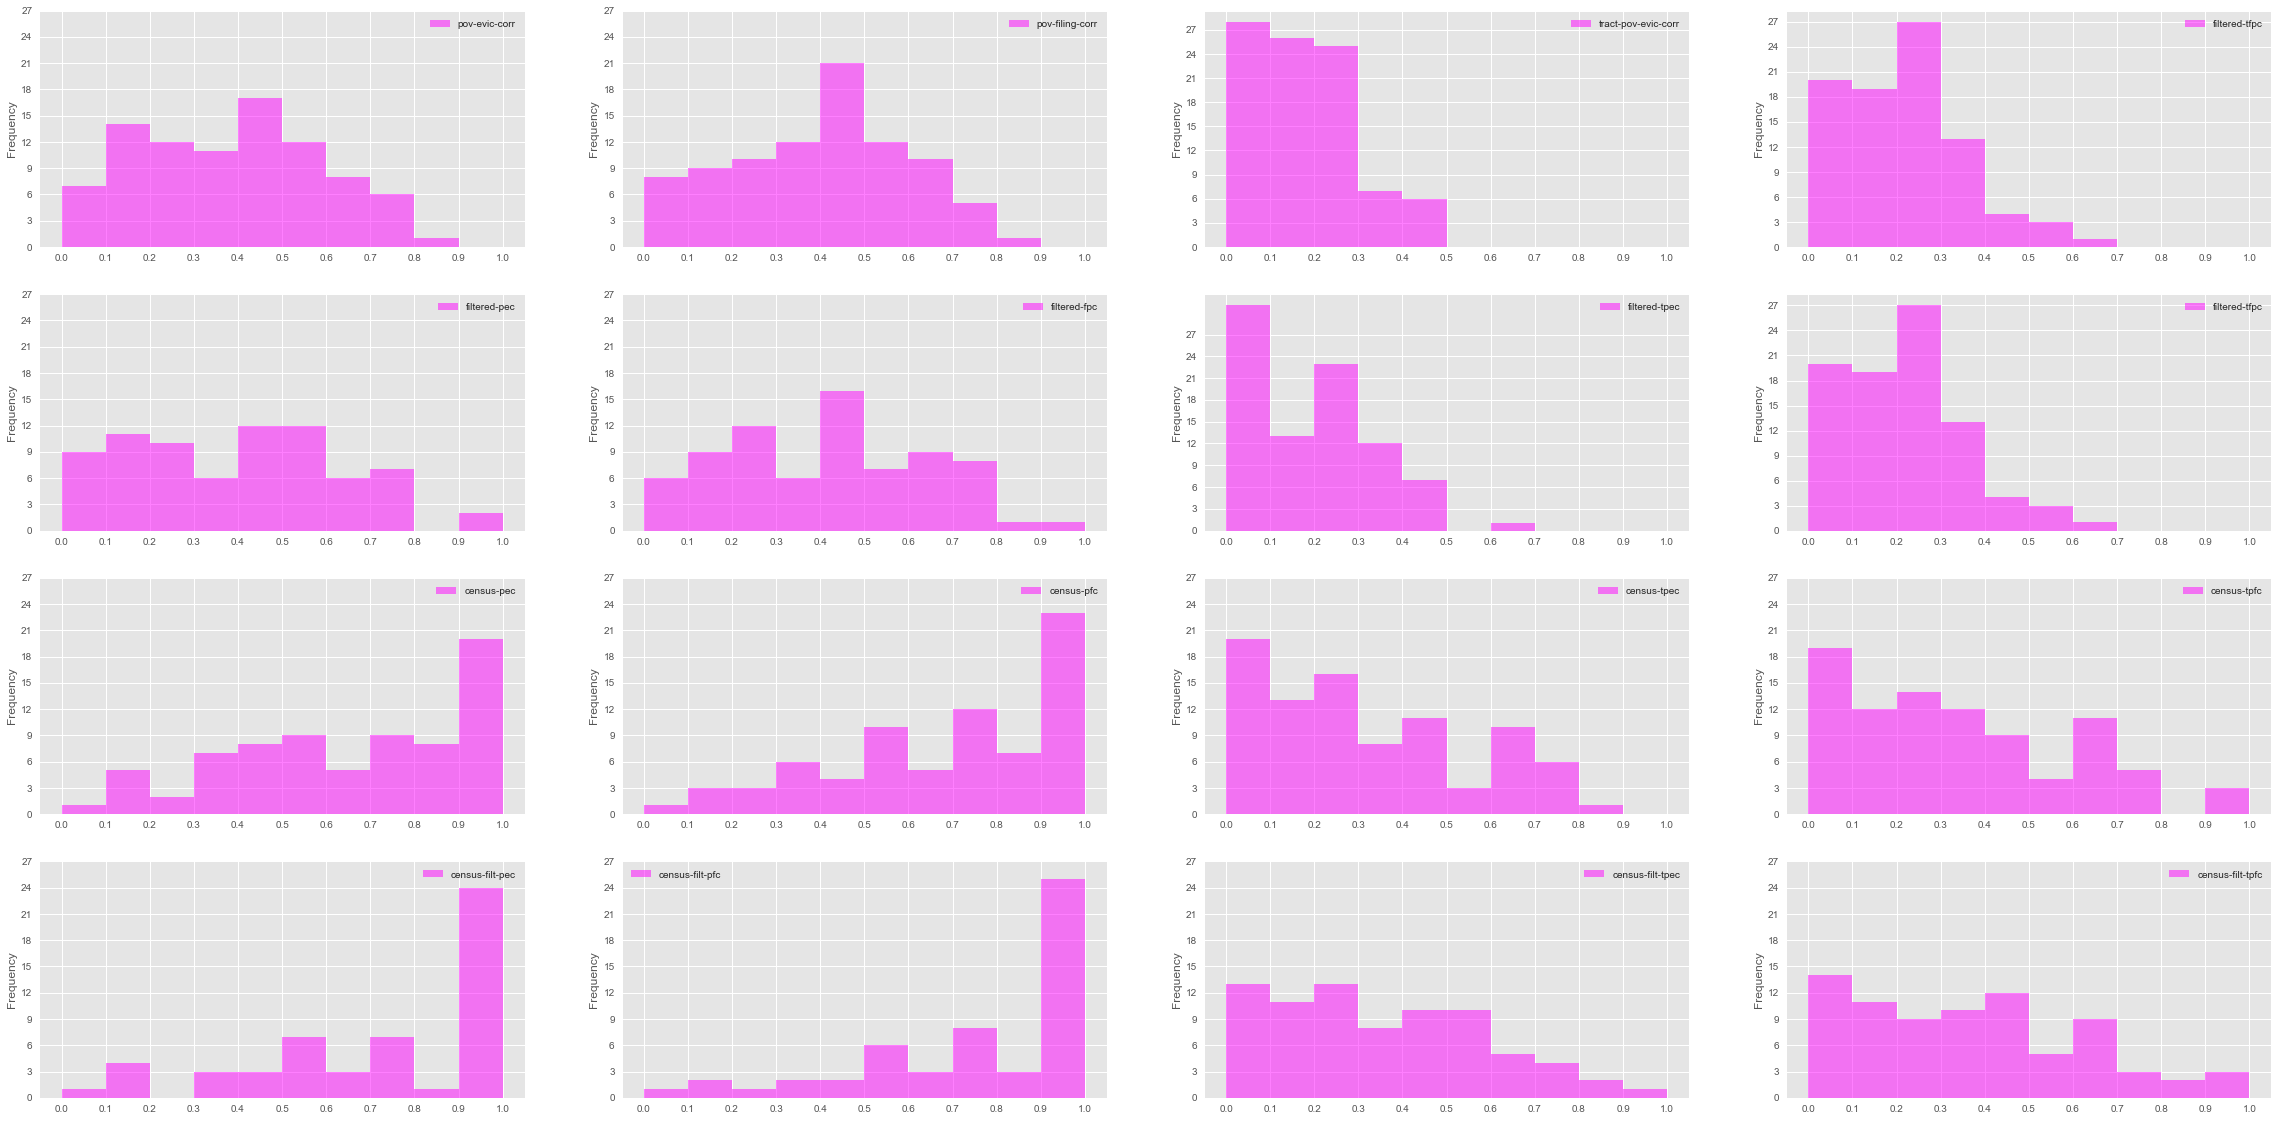

In [960]:
print('Histograms of county correlation coefficients')
county_correlations_df[['pov-evic-corr', 'pov-filing-corr', 'tract-pov-evic-corr', 'filtered-tfpc',
                       'filtered-pec', 'filtered-fpc', 'filtered-tpec', 'filtered-tfpc',
                       'census-pec', 'census-pfc', 'census-tpec', 'census-tpfc',
                       'census-filt-pec', 'census-filt-pfc', 'census-filt-tpec', 'census-filt-tpfc']
                      ].apply(abs).plot(
    subplots = True, layout = (4, 4),
                            kind = 'hist', 
                            alpha = .5, 
                            sharex= False, sharey= False, 
                            figsize= (40, 20), 
                            xticks = np.arange(0, 1.1, .1), yticks = np.arange(0, 30, 3),
                            #xlabelsize = 15, ylabelsize = 15, 
                            bins = 10, color = 'magenta'
                           )
plt.show()

------------------------------ Histograms of county correlation coefficients -------------------------
----------- PEC ---------- ------------ PFC ----------- ------------- TPEC ------------- ----------- TFPC -----------


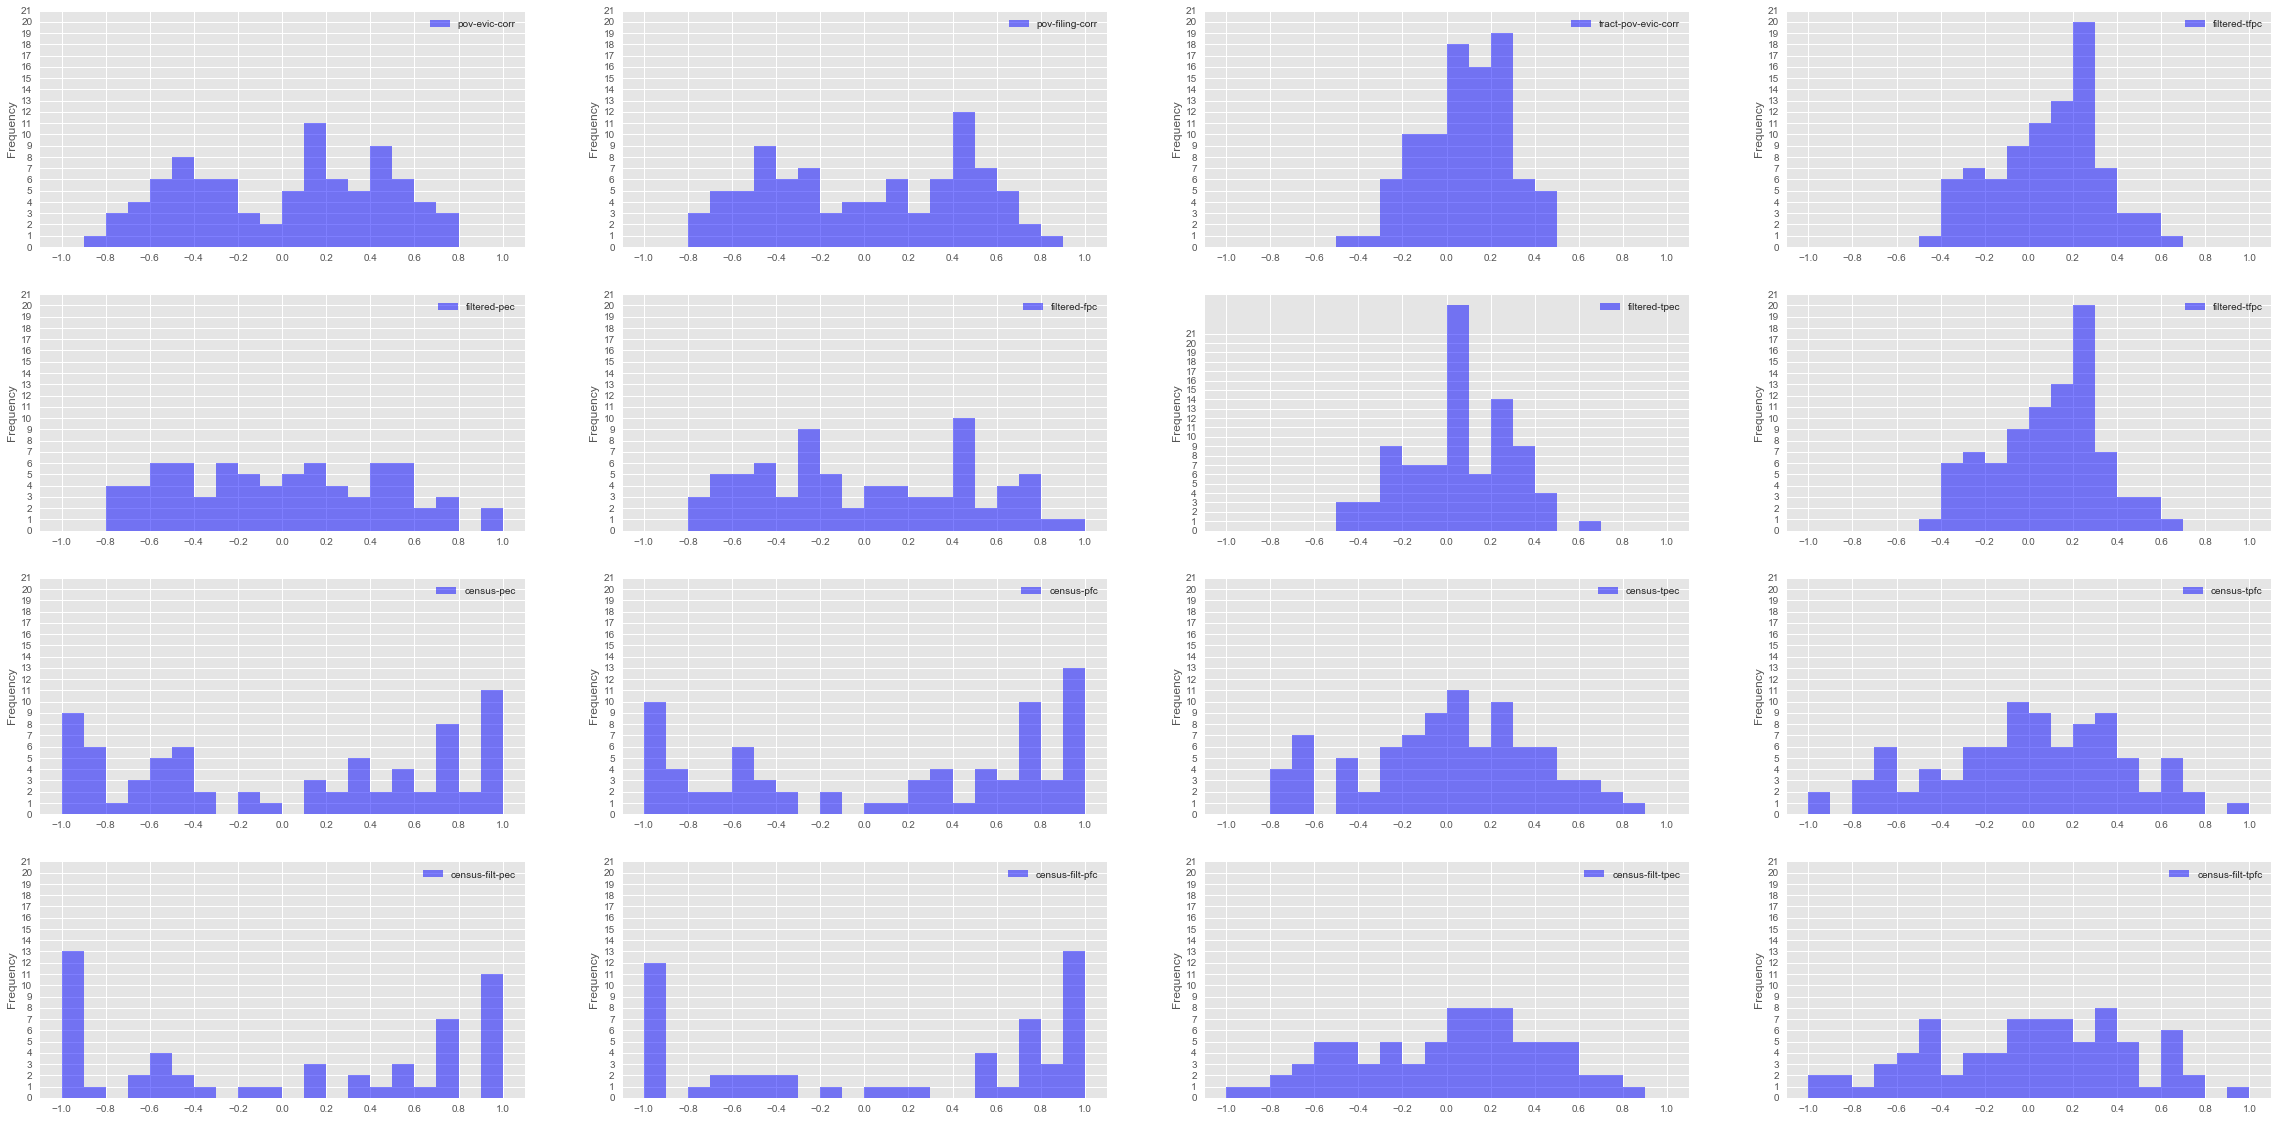

In [963]:
print('-'*30, 'Histograms of county correlation coefficients', '-'*25)
print('----------- PEC ----------', '------------ PFC -----------', '------------- TPEC -------------', '----------- TFPC -----------')
county_correlations_df[['pov-evic-corr', 'pov-filing-corr', 'tract-pov-evic-corr', 'filtered-tfpc',
                       'filtered-pec', 'filtered-fpc', 'filtered-tpec', 'filtered-tfpc',
                       'census-pec', 'census-pfc', 'census-tpec', 'census-tpfc',
                       'census-filt-pec', 'census-filt-pfc', 'census-filt-tpec', 'census-filt-tpfc']
                      ].plot(subplots = True, layout = (4, 4),
                            kind = 'hist', 
                            alpha = .5, 
                            sharex= False, sharey= False, 
                            figsize= (40, 20), 
                            xticks = np.arange(-1, 1.2, .2), yticks = np.arange(0, 22, 1),
                            #xlabelsize = 15, ylabelsize = 15, 
                            #range = (-1, 1), 
                            bins = 20, color = 'blue'
                           )
#plt.title('Histograms of county correlation coefficients')
plt.show()

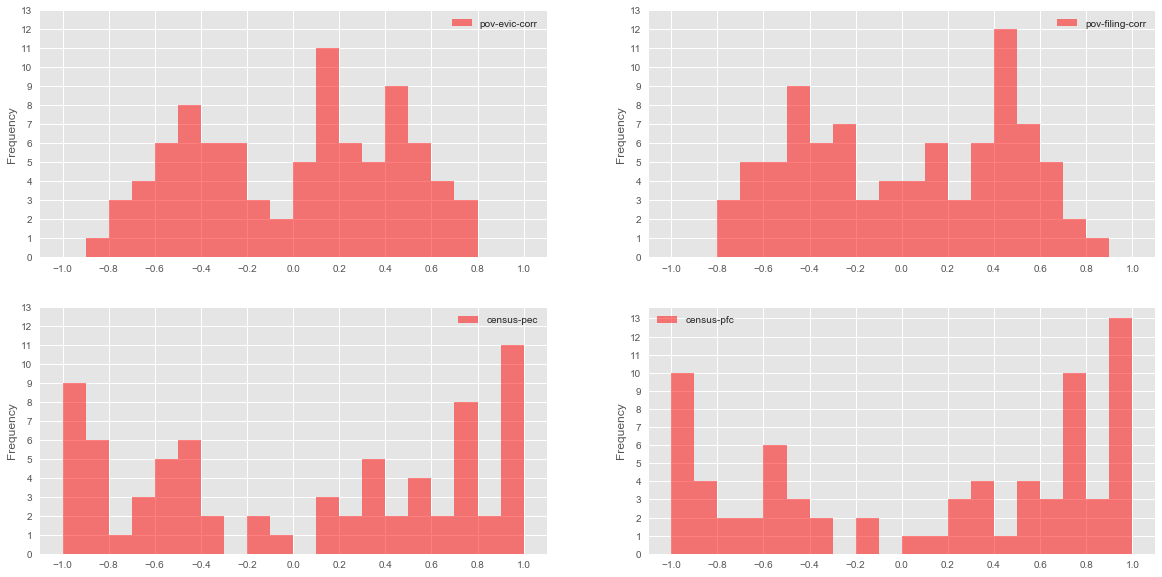

In [975]:
county_correlations_df[['pov-evic-corr', 'pov-filing-corr', #'tract-pov-evic-corr', 'filtered-tfpc',
                       #'filtered-pec', 'filtered-fpc', 'filtered-tpec', 'filtered-tfpc',
                       'census-pec', 'census-pfc'#, 'census-tpec', 'census-tpfc',
                       #'census-filt-pec', 'census-filt-pfc', 'census-filt-tpec', 'census-filt-tpfc'
                       ]].plot(subplots = True, layout = (2, 2),
                            kind = 'hist', 
                            alpha = .5, 
                            sharex= False, sharey= False, 
                            figsize= (20, 10), 
                            xticks = np.arange(-1, 1.2, .2), yticks = np.arange(0, 14, 1),
                            #xlabelsize = 15, ylabelsize = 15, 
                            #range = (-1, 1), 
                            bins = 20, color = 'red'
                           )
#plt.title('Histograms of county correlation coefficients')
plt.show()

# Result: 
**When we filter the data to census years** 
- (when both poverty and eviction are measured in the same year).

**And compute the correlation coefficients for each county it becomes clear that a very significant proportion of TN Counties display a strong correlation between eviction rates and poverty rates**

### What remains interesting and requires further investigation is that the coefficients are either strongly negative or strongly positive


## Exactly How Many Counties Have a Strong Correlation Between Evictions/Filings and Poverty?
- let's start with an empirical cumulative distribution function **ECDF**

In [994]:
def ecdf(data):
    '''Compute (ECDF) 
    Empirical Cumulative Distribution Function 
    for a one-dimensional array of measurements.
    Returns x, y numpy arrays.'''
    # number of data points
    n = len(data)
    
    # x-data for the ECDF: x
    x = np.sort(data)
    
    # y-data for the ECDF: y
    y = np.arange(1, n + 1) / n #just scaling y ticks from 0-1
    
    return x, y

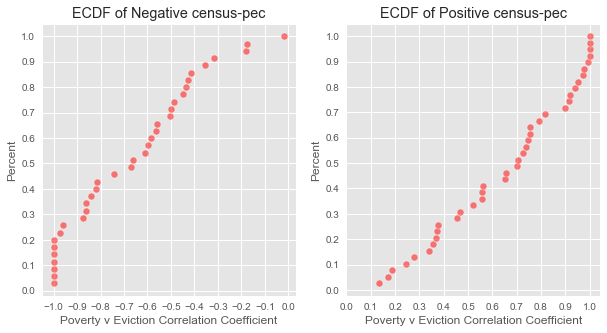

In [1040]:
fig, (ax1, ax2) = plt.subplots(1, 2, 
                         figsize = (10, 5)
                       )
x, y = ecdf(county_correlations_df[
                        [c < 0 for c in county_correlations_df['census-pec']
                        ]]['census-pec'])
ax1.plot(x, y,
         #xticks = np.arange(-1, 0.1, .1), yticks = np.arange(0, 1.1, .1),
         marker = 'o', linestyle = 'none', color = 'red',
            alpha = 0.5, markeredgecolor = 'w' ,
            markeredgewidth = .8,
        #ax = ax2
        )
ax1.xaxis.set_ticks(np.arange(-1, 0.1, .1))
ax1.yaxis.set_ticks(np.arange(0, 1.1, .1))
ax1.set_xlabel('Poverty v Eviction Correlation Coefficient')
ax1.set_ylabel('Percent')
ax1.set_title('ECDF of Negative census-pec')

x, y = ecdf(county_correlations_df[
                        [c > 0 for c in county_correlations_df['census-pec']
                        ]]['census-pec'])
ax2.plot(x, y, 
             marker = 'o', linestyle = 'none', color = 'red',
            alpha = 0.5, markeredgecolor = 'w' ,
            markeredgewidth = .8,
         #ax = ax1
        )
ax2.xaxis.set_ticks(np.arange(0, 1.1, .1))
ax2.yaxis.set_ticks(np.arange(0, 1.1, .1))
ax2.set_xlabel('Poverty v Eviction Correlation Coefficient')
ax2.set_ylabel('Percent')
ax2.set_title('ECDF of Positive census-pec')



plt.show()

#### 67% of Counties have a positive correlation coefficient stronger than .5
### 45% of Counties have a positive correlation coefficient stronger than .75
## 20% of Conties have a positive correlation coefficient stronger than .95

#### 70% of Counties have a negative correlation coefficient stronger than .5
### 45% of Counties have a negative correlation coefficient stronger than .75
## 25% of Conties have a negative correlation coefficient stronger than .95

# Test the Null Hypothesis for these correlation coefficients